In [2]:
from irtracking.capture import PointDetector, Point2D
from irtracking.world import WorldReconstructor
from irtracking.params import IntrinsicParams, ExtrinsicParams
from irtracking.objects import Obj
import numpy as np
import cv2
import json
from pathlib import Path
import rerun as rr
import rerun.blueprint as rrb
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from typing import Tuple, List, Optional
from dataclasses import dataclass
from scipy.spatial import transform

# Load camera parameters
def load_camera_params():
    # Load intrinsic parameters
    with open('config/camera-intrinsic.json', 'r') as f:
        intrinsic_data = json.load(f)
    
    intrinsics = {}
    for cam_data in intrinsic_data:
        camera_id = cam_data['camera_id']
        intrinsics[camera_id] = IntrinsicParams(
            matrix=np.array(cam_data['intrinsic_matrix'], dtype=np.float64),
            distortion=np.array(cam_data['distortion_coef'], dtype=np.float64)
        )
    
    # Initialize extrinsic parameters (identity for now)
    extrinsics = {}
    for camera_id in intrinsics.keys():
        extrinsics[camera_id] = ExtrinsicParams(
            R=np.eye(3),
            t=np.zeros(3)
        )
    
    return intrinsics, extrinsics

# Load calibration videos
def load_calibration_videos():
    videos = []
    for i in range(4):  # Assuming 4 cameras
        cap = cv2.VideoCapture(f'..//footage_calibration//calibration_pose_1_{i}.mp4')
        if not cap.isOpened():
            raise RuntimeError(f"Could not open video file calibration_pose_1_{i}.mp4")
        videos.append(cap)
    return videos

# Test point detection
def detect_points(frame: np.ndarray, intrinsic: IntrinsicParams) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Detect IR LED points in frame"""
        
        undistorted = cv2.undistort(
            frame, 
            intrinsic.matrix,
            intrinsic.distortion
        )
        
        
        # Convert to grayscale
        gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)

        # Process image to find points
        kernel = np.array([[-2, -1, -1, -1, -2],
                         [-1,  1,  3,  1, -1],
                         [-1,  3,  4,  3, -1],
                         [-1,  1,  3,  1, -1],
                         [-2, -1, -1, -1, -2]])
        filtered = cv2.filter2D(gray, -1, kernel)
        
        binary = cv2.threshold(filtered, 255*0.8, 255, cv2.THRESH_BINARY)[1]
        morph = cv2.erode(binary, np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]], np.uint8), iterations=1)
        
        # Find contours
        contours, _ = cv2.findContours(morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Process contours to find points
        points = []
        confidences = []
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = float(M["m10"] / M["m00"])
                cy = float(M["m01"] / M["m00"])
                area = cv2.contourArea(contour)
                confidence = max(0.0, 1.0 - area / 1000)
                points.append([cx, cy])
                confidences.append(confidence)

        return np.array(points), np.array(confidences), morph




def draw_matches(image: np.ndarray, 
                detected_points: np.ndarray, 
                pattern: Obj, 
                pattern_indices: np.ndarray) -> np.ndarray:
    """
    Draw the detected points and their matches to the pattern with gradually changing colors
    """
    img_copy = image.copy()
    
    # Draw detected points in red
    for pt in detected_points:
        cv2.circle(img_copy, tuple(pt.astype(int)), 3, (0,0,255), -1)
    
    # Draw pattern points with color gradient
    num_points = len(pattern_indices)
    for i, idx in enumerate(pattern_indices):
        pt = detected_points[i]
        
        # Create color gradient using HSV (hue varies from 0 to 180 in OpenCV)
        hue = int(180 * idx / num_points)  # Gradually change hue
        hsv_color = np.uint8([[[hue, 255, 255]]])
        bgr_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0][0]
        
        # Draw circle and text in the gradient color
        cv2.circle(img_copy, tuple(pt.astype(int)), 5, bgr_color.tolist(), 1)
        cv2.putText(img_copy, str(idx), tuple(pt.astype(int)), 
                  cv2.FONT_HERSHEY_SIMPLEX, 0.4, bgr_color.tolist(), 1)
    
    return img_copy


def visualize_results(frame_num, frames, processed_frames, points_2d, confidence, world_points, extrinsics, intrinsics, epipolar_lines_list):
    """Visualize results in rerun"""
    # Log timestamp
    rr.set_time_sequence("frame", frame_num)
    
    # Log camera frames and detected 2D points
    for i, frame in enumerate(frames):
        # Log camera frame
        rr.log(f"cameras/camera{i}/image", rr.Image(frame, color_model="BGR").compress(jpeg_quality=75))
        rr.log(f"cameras/camera{i}/image_processed", rr.Image(processed_frames[i], color_model="BGR").compress(jpeg_quality=75))
        
        # Log detected 2D points if available
        if i in points_2d and points_2d[i] is not None and len(points_2d[i]) > 0:
            points_array = points_2d[i]  # Already numpy array
            confidences = confidence[i]  # Assuming equal confidence for now
            
            # Create color array based on confidence
            colors = np.column_stack([
                1.0 - confidences,  # Red channel
                confidences,        # Green channel
                np.zeros_like(confidences),  # Blue channel
                np.ones_like(confidences)    # Alpha channel
            ])
            
            rr.log(f"cameras/camera{i}/points", 
                  rr.Points2D(
                      positions=points_array,
                      colors=colors,
                      radii=3
                  ))
        else:
            rr.log(f"cameras/camera{i}/points", 
                  rr.Points2D(
                      positions=np.array([[None, None]]),
                      colors=np.array([[0, 0, 0, 0]]),
                      radii=3
                  ))
        
        # Log intrinsic parameters
        rr.log(f"cameras/camera{i}/params/int/matrix", 
               rr.TextLog(f"Intrinsic Matrix:\n{np.array2string(intrinsics[i].matrix, precision=4, suppress_small=True)}"))
        rr.log(f"cameras/camera{i}/params/int/distortion", 
               rr.TextLog(f"Distortion Coeffs:\n{np.array2string(intrinsics[i].distortion, precision=4, suppress_small=True)}"))
        
        # Log extrinsic parameters
        if i in extrinsics:
            rr.log(f"cameras/camera{i}/params/ext/rotation", 
                   rr.TextLog(f"Rotation Matrix:\n{np.array2string(extrinsics[i].R, precision=4, suppress_small=True)}"))
            rr.log(f"cameras/camera{i}/params/ext/translation", 
                   rr.TextLog(f"Translation Vector:\n{np.array2string(extrinsics[i].t, precision=4, suppress_small=True)}"))
            
            # Also log euler angles for easier interpretation
            euler = transform.Rotation.from_matrix(extrinsics[i].R).as_euler('xyz', degrees=True)
            rr.log(f"cameras/camera{i}/params/ext/euler_angles", 
                   rr.TextLog(f"Euler Angles (xyz, degrees):\n{np.array2string(euler, precision=2, suppress_small=True)}"))
    
    # Log camera poses in 3D space
    for i, extrinsic in extrinsics.items():
        # Update camera transform and frustum in 3D view
        rr.log(f"cameras/camera{i}",
                rr.Transform3D(
                    translation=extrinsic.t.tolist(),
                    mat3x3=extrinsic.R.tolist(),
                    from_parent=False
                ))
        
        # Log camera intrinsics
        rr.log(f"cameras/camera{i}",
                rr.Pinhole(
                    resolution=[640, 480],  # Adjust if your resolution is different
                    focal_length=[intrinsics[i].matrix[0,0], intrinsics[i].matrix[1,1]],
                    principal_point=[intrinsics[i].matrix[0,2], intrinsics[i].matrix[1,2]],
                    camera_xyz=rr.ViewCoordinates.RUF,
                    #image_plane_distance=10,
                    
                ))
    
    # Log 3D points
    if world_points is not None and len(world_points) > 0:
        points_array = np.array([[p[0], p[1], p[2]] for p in world_points])
        rr.log("world/points",
               rr.Points3D(
                   positions=points_array,
                   colors=[0.0, 1.0, 0.0, 1.0],  # Green points
                   radii=0.01  # 1cm radius
               ))
    else:
        rr.log("world/points",
               rr.Points3D(
                   positions=np.array([[None, None, None]]),
                   colors=np.array([[0, 0, 0, 0]]),
                   radii=0.01  # 1cm radius
               ))
    

def setup_rerun(num_cameras = 4):
    # Initialize rerun blueprint with better layout
            blueprint = rrb.Blueprint(
                rrb.Vertical(
                    rrb.Spatial3DView(
                        name="world",
                        origin="/",
                    ),
                    rrb.Horizontal(
                        *[rrb.Spatial2DView(
                                name=f"camera{i}",
                                origin=f"cameras/camera{i}"
                            ) for i in range(num_cameras)],
                        column_shares=[1] * num_cameras
                    ),
                    row_shares=[2, 1]
                )
            )
            
            # Initialize rerun
            rr.init("IR Tracking Calibration", spawn=True, default_blueprint=blueprint)
            
            rr.set_time_seconds("timestamp", time.time())
            # Setup world view coordinates
            rr.log("/", rr.ViewCoordinates.RUF, static=True)
            
            # Setup camera coordinate systems
            for i in range(num_cameras):
                rr.log(f"cameras/camera{i}", rr.ViewCoordinates.RUF, static=True)  # Right-Down-Forward
            
            rr.log("world", rr.ViewCoordinates.RUF, static=True)  # Set an up-axis
            rr.log("world/origin", rr.Transform3D(translation=[0, 0, 0]))
            rr.log("world/origin/xyz", rr.Arrows3D(
                    origins=[[0, 0, 0], [0, 0, 0], [0, 0, 0]],
                    vectors=[[50, 0, 0], [0, 50, 0], [0, 0, 50]],
                    colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
                    labels=["X", "Y", "Z"],
                    show_labels=False
                )
            )
            


In [3]:
# First cell - imports and setup
import numpy as np
import cv2
import json
from pathlib import Path
import rerun as rr
import rerun.blueprint as rrb
from scipy.spatial.distance import cdist
from scipy.spatial.transform import Rotation
from scipy.optimize import linear_sum_assignment
from typing import Tuple, List, Optional
from dataclasses import dataclass
import time
from IPython.display import clear_output

# Initialize video captures
def init_calibration():
    videos = []
    for i in range(4):  # Assuming 4 cameras
        cap = cv2.VideoCapture(f'../footage_calibration/calibration1_{i}.mp4')
        if not cap.isOpened():
            raise RuntimeError(f"Could not open video file calibration1_{i}.mp4")
        videos.append(cap)
    
    # Load camera parameters
    with open('config/camera-intrinsic.json', 'r') as f:
        intrinsic_data = json.load(f)
    
    intrinsics = {}
    for cam_data in intrinsic_data:
        camera_id = cam_data['camera_id']
        intrinsics[camera_id] = IntrinsicParams(
            matrix=np.array(cam_data['intrinsic_matrix'], dtype=np.float64),
            distortion=np.array(cam_data['distortion_coef'], dtype=np.float64)
        )
    
    # Initialize extrinsic parameters (identity for now)
    extrinsics = {}
    for camera_id in intrinsics.keys():
        extrinsics[camera_id] = ExtrinsicParams(
            R=np.eye(3),
            t=np.zeros(3)
        )
    
    return videos, intrinsics, extrinsics

# Load calibration pattern
def load_calibration_pattern():
    pattern = Obj.from_dict({
        "name": "calibrator_1",
        "type": "calibrator",
        "dimensions": 2,
        "metadata": {"units": "mm"},
        "points": [
            [0, 0],
            [100, 100],
            [200, 200],
            [-100, -100],
            [-200, -200],
            [0, 100],
            [-200, 200],
            [-100, 200],
            [-100, 100],
            [-100, 0],
            [-100, -200],
            [0, -200],
            [100, -200],
            [200, -200],
            [200, -100]
        ]
    })
    return pattern


def get_point_signature(points: np.ndarray, idx: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create a signature for a point using both distances and angles to nearby points
    Returns: (distances, angles)
    """
    # Get vectors to all other points
    vectors = points - points[idx]
    
    # Calculate distances
    distances = np.linalg.norm(vectors, axis=1)
    
    # Calculate angles (relative to positive x-axis)
    angles = np.arctan2(vectors[:, 1], vectors[:, 0])
    
    # Sort by distance to maintain consistent ordering
    sort_idx = np.argsort(distances)
    return distances[sort_idx], angles[sort_idx]

def angle_difference(angle1: float, angle2: float) -> float:
    """Calculate minimum angle difference between two angles in radians"""
    diff = abs(angle1 - angle2)
    return min(diff, 2*np.pi - diff)

def match_pattern_to_detections(detected_points: np.ndarray, pattern: Obj, max_scale_diff: float = 0.2) -> Optional[np.ndarray]:
    """
    Improved pattern matching using both distances and angles
    """
    if len(detected_points) < 4:
        return None

    # transform pattern points to image space
    pattern_points = pattern.points
    pattern_points[:, 1] = -pattern_points[:, 1]  # Flip Y
    #offset by 320, 240
    pattern_points[:, 0] += 320
    pattern_points[:, 1] += 240

    # Normalize both point sets
    pattern_norm, pattern_scale = normalize_points(pattern_points)
    detected_norm, detected_scale = normalize_points(detected_points)


    # Build cost matrix using both distance and angle information
    cost_matrix = np.zeros((len(detected_points), len(pattern.points)))

    for i in range(len(detected_points)):
        # Get signature for detected point
        det_dists, det_angles = get_point_signature(detected_norm, i)
        
        for j in range(len(pattern.points)):
            # Get signature for pattern point
            pat_dists, pat_angles = get_point_signature(pattern_norm, j)
            
            # Match lengths
            min_len = min(len(det_dists), len(pat_dists))
            det_dists = det_dists[:min_len]
            det_angles = det_angles[:min_len]
            pat_dists = pat_dists[:min_len]
            pat_angles = pat_angles[:min_len]
            
            # Calculate distance signature similarity
            dist_corr = np.corrcoef(det_dists, pat_dists)[0,1]
            
            # Calculate angle differences (considering rotation)
            # For each possible rotation offset
            best_angle_cost = float('inf')
            for k in range(min_len):
                # Rotate angles
                rotated_angles = np.roll(pat_angles, k)
                # Calculate angle differences
                angle_diffs = [angle_difference(a1, a2) for a1, a2 in zip(det_angles, rotated_angles)]
                angle_cost = np.mean(angle_diffs)
                best_angle_cost = min(best_angle_cost, angle_cost)
            
            # Combine distance and angle costs
            # Higher weight on angle differences as they're more discriminative
            cost_matrix[i,j] = -dist_corr + 2.0 * best_angle_cost

    # Use Hungarian algorithm for optimal matching
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Verify match quality
    match_cost = cost_matrix[row_ind, col_ind].mean()
    
    return col_ind

def verify_pattern_match(detected_points: np.ndarray, pattern: Obj, matches: np.ndarray) -> bool:
    """
    Additional verification of pattern match using geometric constraints
    """
    # Convert matches to reordered points
    ordered_points = detected_points[np.argsort(matches)]
    
    # Verify key distances are preserved (within tolerance)
    pattern_dists = cdist(pattern.points, pattern.points)
    detected_dists = cdist(ordered_points, ordered_points)
    
    # Scale to match pattern size
    scale = np.median(detected_dists / (pattern_dists + 1e-10))
    dist_error = np.abs(detected_dists - scale * pattern_dists)
    
    # Check if distance errors are within tolerance
    max_allowed_error = scale * 10  # 10mm tolerance scaled by detected pattern size
    if np.max(dist_error) > max_allowed_error:
        return False
    
    return True

def find_pattern_scale(obj: Obj) -> float:
    """Find the characteristic scale of the pattern (largest distance between points)"""
    distances = cdist(obj.points, obj.points)
    return np.max(distances)

def normalize_points(points: np.ndarray) -> Tuple[np.ndarray, float]:
    """Center points and normalize scale"""
    centroid = np.mean(points, axis=0)
    centered = points - centroid
    scale = np.max(np.linalg.norm(centered, axis=1))
    normalized = centered / scale
    return normalized, scale


def estimate_camera_pose(image_points: np.ndarray, pattern: Obj, camera_matrix: np.ndarray, dist_coeffs: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Estimate camera pose using PnP algorithm
    Returns rotation matrix and translation vector
    """
    # Convert 2D pattern to 3D by adding Z=0
    object_points = np.hstack((pattern.points, np.zeros((len(pattern.points), 1))))
    
    # Use RANSAC-based PnP for robust estimation
    success, rotation_vec, translation_vec, inliers = cv2.solvePnPRansac(
        object_points.astype(np.float32),
        image_points.astype(np.float32),
        camera_matrix,
        dist_coeffs,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    
    if not success:
        raise RuntimeError("Failed to estimate pose")
    
    # Convert rotation vector to matrix
    rotation_mat, _ = cv2.Rodrigues(rotation_vec)
    
    return rotation_mat, translation_vec

def calibrate_multi_camera(detected_points_list: List[np.ndarray], 
                         pattern: Obj, 
                         camera_matrices: List[np.ndarray],
                         dist_coeffs_list: List[np.ndarray]) -> List[dict]:
    """
    Calibrate multiple cameras using pattern detections
    Returns list of camera poses (R, t) relative to first camera
    """
    camera_poses = []
    base_R = None
    base_t = None
    
    for i, (points, cam_mat, dist_coeffs) in enumerate(zip(detected_points_list, camera_matrices, dist_coeffs_list)):
        # Match detected points to pattern
        pattern_indices = match_pattern_to_detections(points, pattern)
        if pattern_indices is None:
            raise RuntimeError(f"Failed to match pattern in camera {i}")
            
        # Reorder points to match pattern
        ordered_points = points[np.argsort(pattern_indices)]
        
        # Get camera pose relative to pattern
        R, t = estimate_camera_pose(ordered_points, pattern, cam_mat, dist_coeffs)
        
        if i == 0:
            # First camera becomes our reference frame
            base_R = R
            base_t = t
            camera_poses.append({"R": np.eye(3), "t": np.zeros(3)})
        else:
            # Convert pose to be relative to first camera
            relative_R = R @ base_R.T
            relative_t = t - relative_R @ base_t
            camera_poses.append({"R": relative_R, "t": relative_t.flatten()})
    
    return camera_poses
# Process single frame
def process_frame(videos, intrinsics, extrinsics, pattern, frame_num):
    frames = []
    points_2d = {}
    confidences = {}
    processed_frames = []
    pattern_matches = []
    
    # Read and process frames
    for i, cap in enumerate(videos):
        ret, frame = cap.read()
        if not ret:
            print(f"End of video {i}")
            return None, None, None, None, None
            
        frames.append(frame)
        
        # Detect points
        points, confidence, processed = detect_points(frame, intrinsics[i])
        points_2d[i] = points
        confidences[i] = confidence
        processed_frames.append(cv2.cvtColor(processed, cv2.COLOR_GRAY2BGR))
        
        # Try to match pattern
        if len(points) > 0:
            pattern_idx = match_pattern_to_detections(points, pattern)
            if pattern_idx is not None:# and verify_pattern_match(points, pattern, pattern_idx):
                ordered_points = points[np.argsort(pattern_idx)]
                pattern_matches.append((i, ordered_points))
                
                # Visualize matches
                matched_frame = draw_matches(frame, points, pattern, pattern_idx)
                processed_frames[i] = matched_frame
    
    # Update camera poses if we have enough matches
    if len(pattern_matches) >= 2:
        # Extract camera matrices and points
        cam_matrices = []
        dist_coeffs = []
        detected_points = []
        
        for cam_id, points in pattern_matches:
            cam_matrices.append(intrinsics[cam_id].matrix)
            dist_coeffs.append(intrinsics[cam_id].distortion)
            detected_points.append(points)
        
        try:
            # Update camera poses
            new_poses = calibrate_multi_camera(detected_points, pattern, cam_matrices, dist_coeffs)
            
            # Update extrinsics
            for i, pose in enumerate([pm[0] for pm in pattern_matches]):
                extrinsics[pose] = ExtrinsicParams(
                    R=new_poses[i]["R"],
                    t=new_poses[i]["t"]
                )
        except RuntimeError as e:
            print(f"Calibration failed: {e}")
    
    return frames, processed_frames, points_2d, confidences, extrinsics

# Visualization function
def display_frames(frames, processed_frames):
    n_cameras = len(frames)
    fig_size = 5
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(fig_size * 2, fig_size * n_cameras))
    
    for i in range(n_cameras):
        # Original frame
        plt.subplot(n_cameras, 2, 2*i + 1)
        plt.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Camera {i} - Original')
        plt.axis('off')
        
        # Processed frame
        plt.subplot(n_cameras, 2, 2*i + 2)
        plt.imshow(cv2.cvtColor(processed_frames[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Camera {i} - Processed')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to print current extrinsics
def print_extrinsics(extrinsics):
    for cam_id, params in extrinsics.items():
        print(f"\nCamera {cam_id}:")
        print("Rotation Matrix:")
        print(params.R)
        print("Translation Vector:")
        print(params.t)
        # Convert rotation to euler angles for easier interpretation
        euler = Rotation.from_matrix(params.R).as_euler('xyz', degrees=True)
        print("Euler Angles (xyz, degrees):")
        print(euler)

In [4]:
import matplotlib.pyplot as plt

# Initialize
videos, intrinsics, extrinsics = init_calibration()
pattern = load_calibration_pattern()
frame_num = 0

Calibration failed: Failed to estimate pose


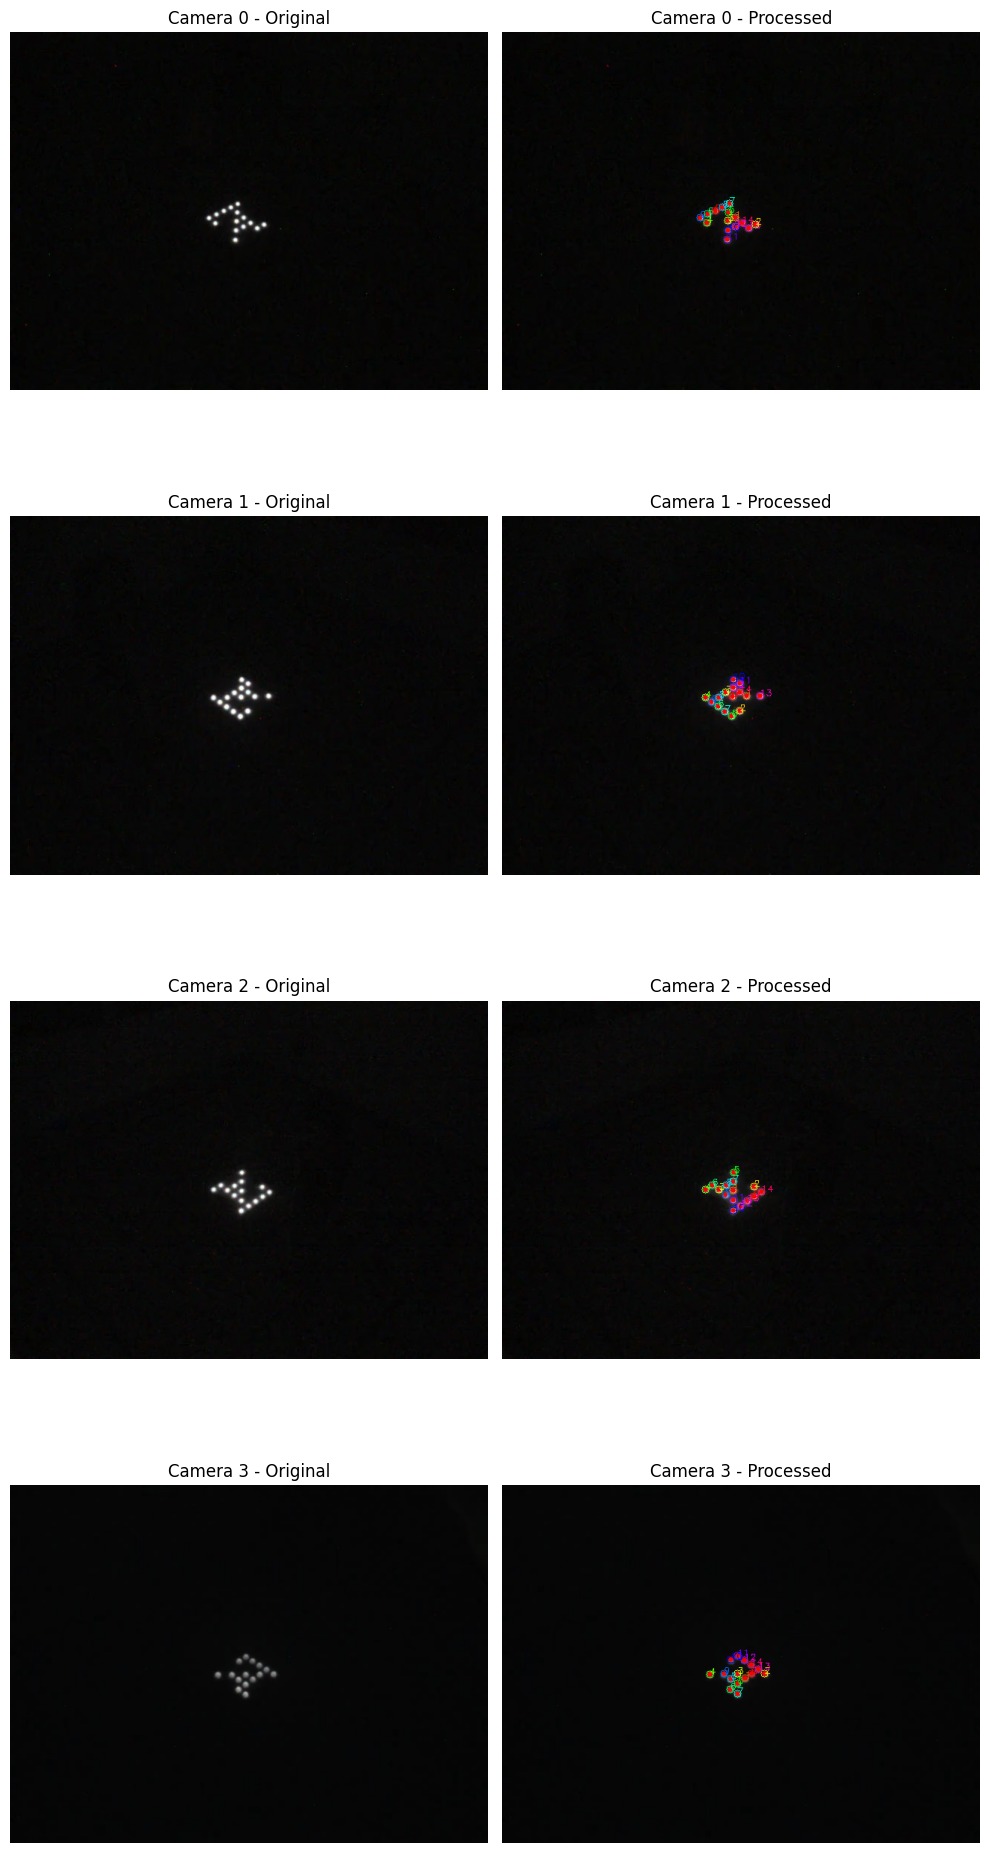


Camera 0:
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[0. 0. 0.]
Euler Angles (xyz, degrees):
[0. 0. 0.]

Camera 1:
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[0. 0. 0.]
Euler Angles (xyz, degrees):
[0. 0. 0.]

Camera 2:
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[0. 0. 0.]
Euler Angles (xyz, degrees):
[0. 0. 0.]

Camera 3:
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[0. 0. 0.]
Euler Angles (xyz, degrees):
[0. 0. 0.]


In [5]:
# Cell 2 - Run this cell repeatedly to process frames one by one
frames, processed_frames, points_2d, confidences, extrinsics = process_frame(videos, intrinsics, extrinsics, pattern, frame_num)
if frames is not None:
    display_frames(frames, processed_frames)
    print_extrinsics(extrinsics)
    frame_num += 1
else:
    print("End of videos")

# Test Initialization

## Load Video

In [6]:
# Initialize video captures
def init_calibration():
    videos = []
    for i in range(4):  # Assuming 4 cameras
        cap = cv2.VideoCapture(f'../footage_calibration/calibration1_{i}.mp4')
        if not cap.isOpened():
            raise RuntimeError(f"Could not open video file calibration1_{i}.mp4")
        videos.append(cap)
    
    # Load camera parameters
    with open('config/camera-intrinsic.json', 'r') as f:
        intrinsic_data = json.load(f)
    
    intrinsics = {}
    for cam_data in intrinsic_data:
        camera_id = cam_data['camera_id']
        intrinsics[camera_id] = IntrinsicParams(
            matrix=np.array(cam_data['intrinsic_matrix'], dtype=np.float64),
            distortion=np.array(cam_data['distortion_coef'], dtype=np.float64)
        )
    
    # Initialize extrinsic parameters (identity for now)
    extrinsics = {}
    for camera_id in intrinsics.keys():
        extrinsics[camera_id] = ExtrinsicParams(
            R=np.eye(3),
            t=np.zeros(3)
        )
    
    return videos, intrinsics, extrinsics

# Load calibration pattern
def load_calibration_pattern():
    pattern = Obj.from_dict({
        "name": "calibrator_1",
        "type": "calibrator",
        "dimensions": 2,
        "metadata": {"units": "mm"},
        "points": [
            [0, 0],
            [100, 100],
            [200, 200],
            [-100, -100],
            [-200, -200],
            [0, 100],
            [-200, 200],
            [-100, 200],
            [-100, 100],
            [-100, 0],
            [-100, -200],
            [0, -200],
            [100, -200],
            [200, -200],
            [200, -100]
        ]
    })
    return pattern



In [7]:
#=================================================
videos, intrinsics, extrinsics = init_calibration()
pattern = load_calibration_pattern()

# Read all videos and store as video_frames[camera_id][frame_num]
video_frames = []
for i in range(len(videos)):
    frames = []
    while True:
        ret, frame = videos[i].read()
        if not ret:
            print(f"End of video {i}")
            videos[i].release()
            break
        frames.append(frame)
    video_frames.append(frames)


End of video 0
End of video 1
End of video 2
End of video 3


In [8]:
len(video_frames[0])

1202

## Detect Points

In [9]:
# Test point detection
def detect_points(frame: np.ndarray, intrinsic: IntrinsicParams) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Detect IR LED points in frame"""
        
        undistorted = cv2.undistort(
            frame, 
            intrinsic.matrix,
            intrinsic.distortion
        )
        
        
        # Convert to grayscale
        gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)

        # Process image to find points
        kernel = np.array([[-2, -1, -1, -1, -2],
                         [-1,  1,  3,  1, -1],
                         [-1,  3,  4,  3, -1],
                         [-1,  1,  3,  1, -1],
                         [-2, -1, -1, -1, -2]])
        filtered = cv2.filter2D(gray, -1, kernel)
        
        binary = cv2.threshold(filtered, 255*0.8, 255, cv2.THRESH_BINARY)[1]
        morph = cv2.erode(binary, np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]], np.uint8), iterations=1)
        
        # Find contours
        contours, _ = cv2.findContours(morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Process contours to find points
        points = []
        confidences = []
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = float(M["m10"] / M["m00"])
                cy = float(M["m01"] / M["m00"])
                area = cv2.contourArea(contour)
                confidence = max(0.0, 1.0 - area / 1000)
                points.append([cx, cy])
                confidences.append(confidence)

        return np.array(points), np.array(confidences), morph

detected_points = [[detect_points(frame, intrinsics[i])[0] for frame in video_frames[i]] for i in range(len(video_frames))]

In [10]:
detected_points[0]


[array([[301.2962963 , 278.68518519],
        [302.26666667, 266.15      ],
        [330.56862745, 263.43137255],
        [312.35416667, 261.5       ],
        [339.56862745, 258.43137255],
        [321.5       , 256.35416667],
        [274.43137255, 256.56862745],
        [302.75438596, 253.61403509],
        [312.5       , 249.        ],
        [265.75438596, 249.61403509],
        [275.66666667, 244.74358974],
        [303.5       , 242.35416667],
        [285.625     , 240.        ],
        [295.42222222, 235.42222222],
        [304.5       , 230.64583333]]),
 array([[301.        , 279.        ],
        [302.        , 266.        ],
        [330.5       , 263.13333333],
        [312.        , 261.        ],
        [339.9047619 , 258.0952381 ],
        [274.5       , 256.86666667],
        [321.62962963, 256.07407407],
        [303.        , 254.        ],
        [312.0952381 , 248.9047619 ],
        [266.        , 249.5       ],
        [276.        , 245.        ],
        [3

# Object Pattern Matching and Object Pose Estimation

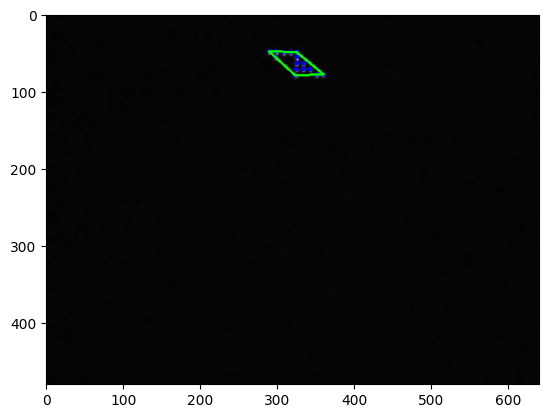

In [11]:
import numpy as np
import cv2

def find_corners(points):
    """Find corners in order: top-left, top-right, bottom-right, bottom-left"""
    points = np.array(points)
    
    # Compute the center of mass
    center = np.mean(points, axis=0)
    
    # Compute angles from center to each point
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    
    # Sort points by angle
    sorted_indices = np.argsort(angles)
    sorted_points = points[sorted_indices]
    
    # If we have many points, we need to find the actual corners
    if len(points) > 4:
        # Use convex hull to find the boundary points
        hull = cv2.convexHull(sorted_points.astype(np.float32))
        hull_points = hull.reshape(-1, 2)
        
        # If hull has more than 4 points, we need to simplify to get 4 corners
        if len(hull_points) > 4:
            # Find the 4 points with maximum distance between them
            # This is a simplification - you might need a more sophisticated approach
            peri = cv2.arcLength(hull, True)
            approx = cv2.approxPolyDP(hull, 0.02 * peri, True)
            corners = approx.reshape(-1, 2)
            
            # Make sure we have exactly 4 corners
            if len(corners) != 4:
                # If not, find the 4 points furthest from each other
                from scipy.spatial.distance import pdist, squareform
                dist_mat = squareform(pdist(hull_points))
                indices = np.zeros(4, dtype=np.int32)
                
                # Start with the two points furthest apart
                i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
                indices[0], indices[1] = i, j
                
                # Find third point furthest from first two
                dist_from_selected = dist_mat[indices[0]] + dist_mat[indices[1]]
                remaining = list(set(range(len(hull_points))) - set(indices[:2]))
                indices[2] = remaining[np.argmax(dist_from_selected[remaining])]
                
                # Find fourth point furthest from first three
                dist_from_selected = (dist_mat[indices[0]] + dist_mat[indices[1]] + 
                                      dist_mat[indices[2]])
                remaining = list(set(range(len(hull_points))) - set(indices[:3]))
                indices[3] = remaining[np.argmax(dist_from_selected[remaining])]
                
                corners = hull_points[indices]
        else:
            corners = hull_points
    else:
        corners = sorted_points
    
    # Ensure we have 4 corners
    if len(corners) != 4:
        raise ValueError(f"Expected 4 corners, but found {len(corners)}")
    
    # Sort corners to top-left, top-right, bottom-right, bottom-left order
    # Sort by x+y value first (to separate diagonal corners)
    corner_sum = corners[:, 0] + corners[:, 1]
    
    # The corner with minimum sum is top-left, maximum sum is bottom-right
    tl_idx = np.argmin(corner_sum)
    br_idx = np.argmax(corner_sum)
    
    # The other two corners can be distinguished by x-y value
    remaining_idx = [i for i in range(4) if i != tl_idx and i != br_idx]
    corner_diff = corners[remaining_idx, 0] - corners[remaining_idx, 1]
    
    # The corner with minimum difference is bottom-left, maximum is top-right
    if corner_diff[0] < corner_diff[1]:
        bl_idx, tr_idx = remaining_idx
    else:
        tr_idx, bl_idx = remaining_idx
    
    # Return corners in the specified order
    return np.array([
        corners[tl_idx],  # top-left
        corners[tr_idx],  # top-right
        corners[br_idx],  # bottom-right
        corners[bl_idx]   # bottom-left
    ])

def draw_square(img, corners, color=(0, 255, 0), thickness=2):
    """Draw a square given four corners"""
    corners = corners.astype(np.int32)
    
    # Draw lines between corners
    for i in range(4):
        cv2.line(img, 
                 tuple(corners[i]), 
                 tuple(corners[(i+1)%4]), 
                 color, 
                 thickness)
    
    return img

# Example usage:
img = video_frames[0][299].copy()

points = detected_points[0][299]

# Find corners
corners = find_corners(points)

# Draw all points
for point in points:
    cv2.circle(img, tuple(point.astype(int)), 3, (0, 0, 255), -1)

# Draw square
img = draw_square(img, corners)

# Display
plt.imshow(img)

### Render detected points and corners into a video

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

def create_corner_detection_videos(video_frames, detected_points, output_dir="./footage/"):
    """
    Process all video frames, detect corners, and create videos.
    
    Args:
        video_frames: List of lists where video_frames[cam_id][frame_num] contains the frame image
        detected_points: List of lists where detected_points[cam_id][frame_num] contains detected points
        output_dir: Directory to save output videos
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each camera
    for cam_id in range(len(video_frames)):
        num_frames = len(video_frames[cam_id])
        
        # Get frame dimensions from the first frame
        first_frame = video_frames[cam_id][0]
        height, width = first_frame.shape[:2]
        
        # Set up video writer
        output_path = os.path.join(output_dir, f"calibration_corner_detection_{cam_id}.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID'
        fps = 30
        video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        print(f"Processing camera {cam_id} ({num_frames} frames)...")
        
        # Process each frame
        for frame_num in tqdm(range(num_frames)):
            # Get frame and points
            frame = video_frames[cam_id][frame_num].copy()
            points = detected_points[cam_id][frame_num]
            
            # Skip frame if no points detected
            if len(points) == 0:
                video_writer.write(frame)
                continue
            
            try:
                # Find corners
                corners = find_corners(points)
                
                # Draw all points
                for point in points:
                    cv2.circle(frame, tuple(point.astype(int)), 3, (0, 0, 255), -1)
                
                # Draw square
                frame = draw_square(frame, corners)
                
                # Add frame number text
                cv2.putText(frame, f"Frame: {frame_num}", (10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                
            except Exception as e:
                # Draw error message if corner detection fails
                cv2.putText(frame, f"Error: {str(e)}", (10, 60), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            # Convert frame to proper color format if needed
            if len(frame.shape) == 2:  # if grayscale
                frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            elif frame.shape[2] == 4:  # if RGBA
                frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
            
            # Write frame to video
            video_writer.write(frame)
        
        # Release video writer
        video_writer.release()
        print(f"Video saved to {output_path}")
    
    print("All videos created successfully.")

In [13]:
#create_corner_detection_videos(video_frames, detected_points)

## Point Correspondance Detection

Best transformation: Rotation = 90°, Mirror = horizontal
Average matching error: 53.20


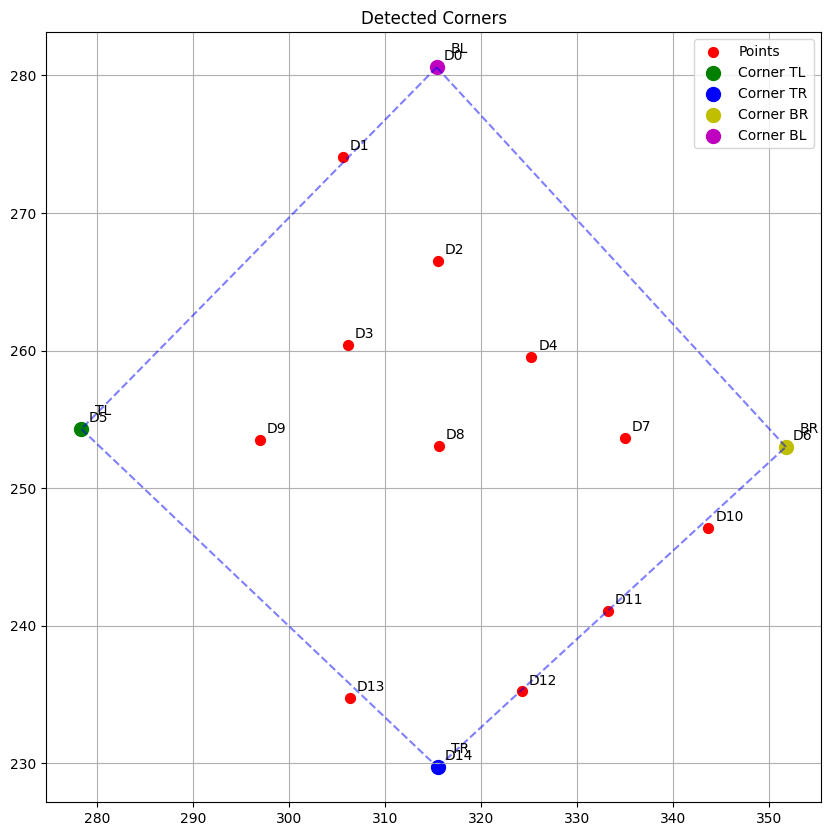

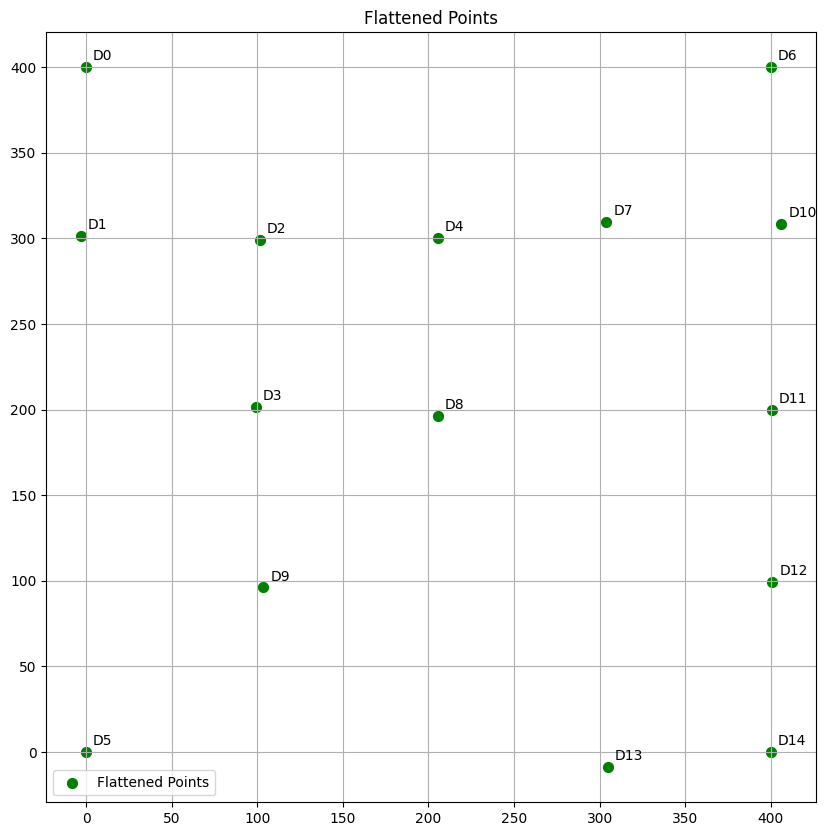

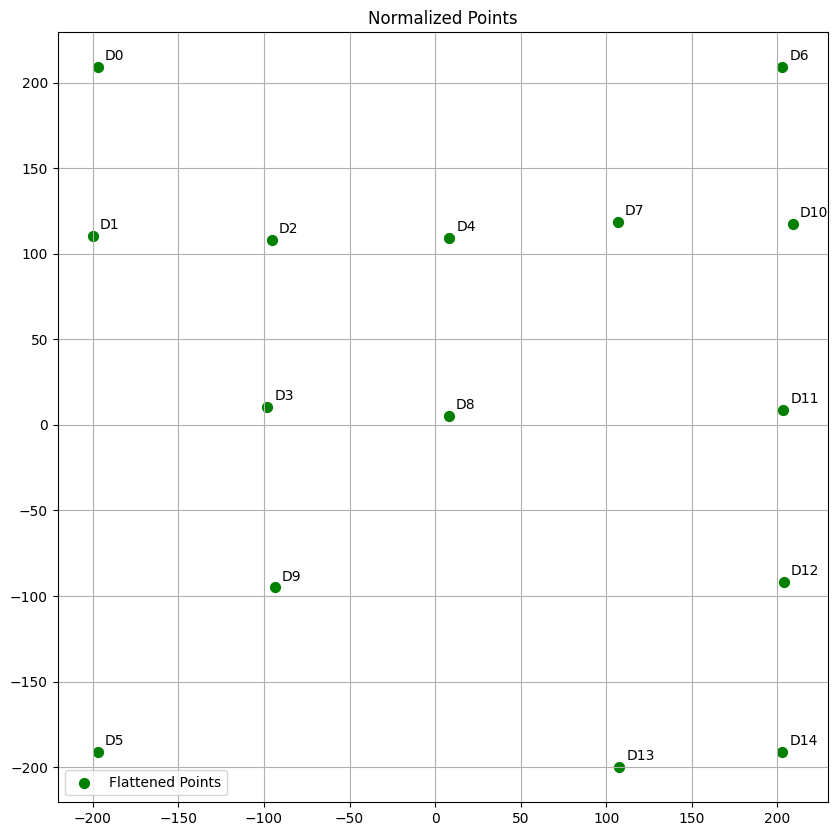

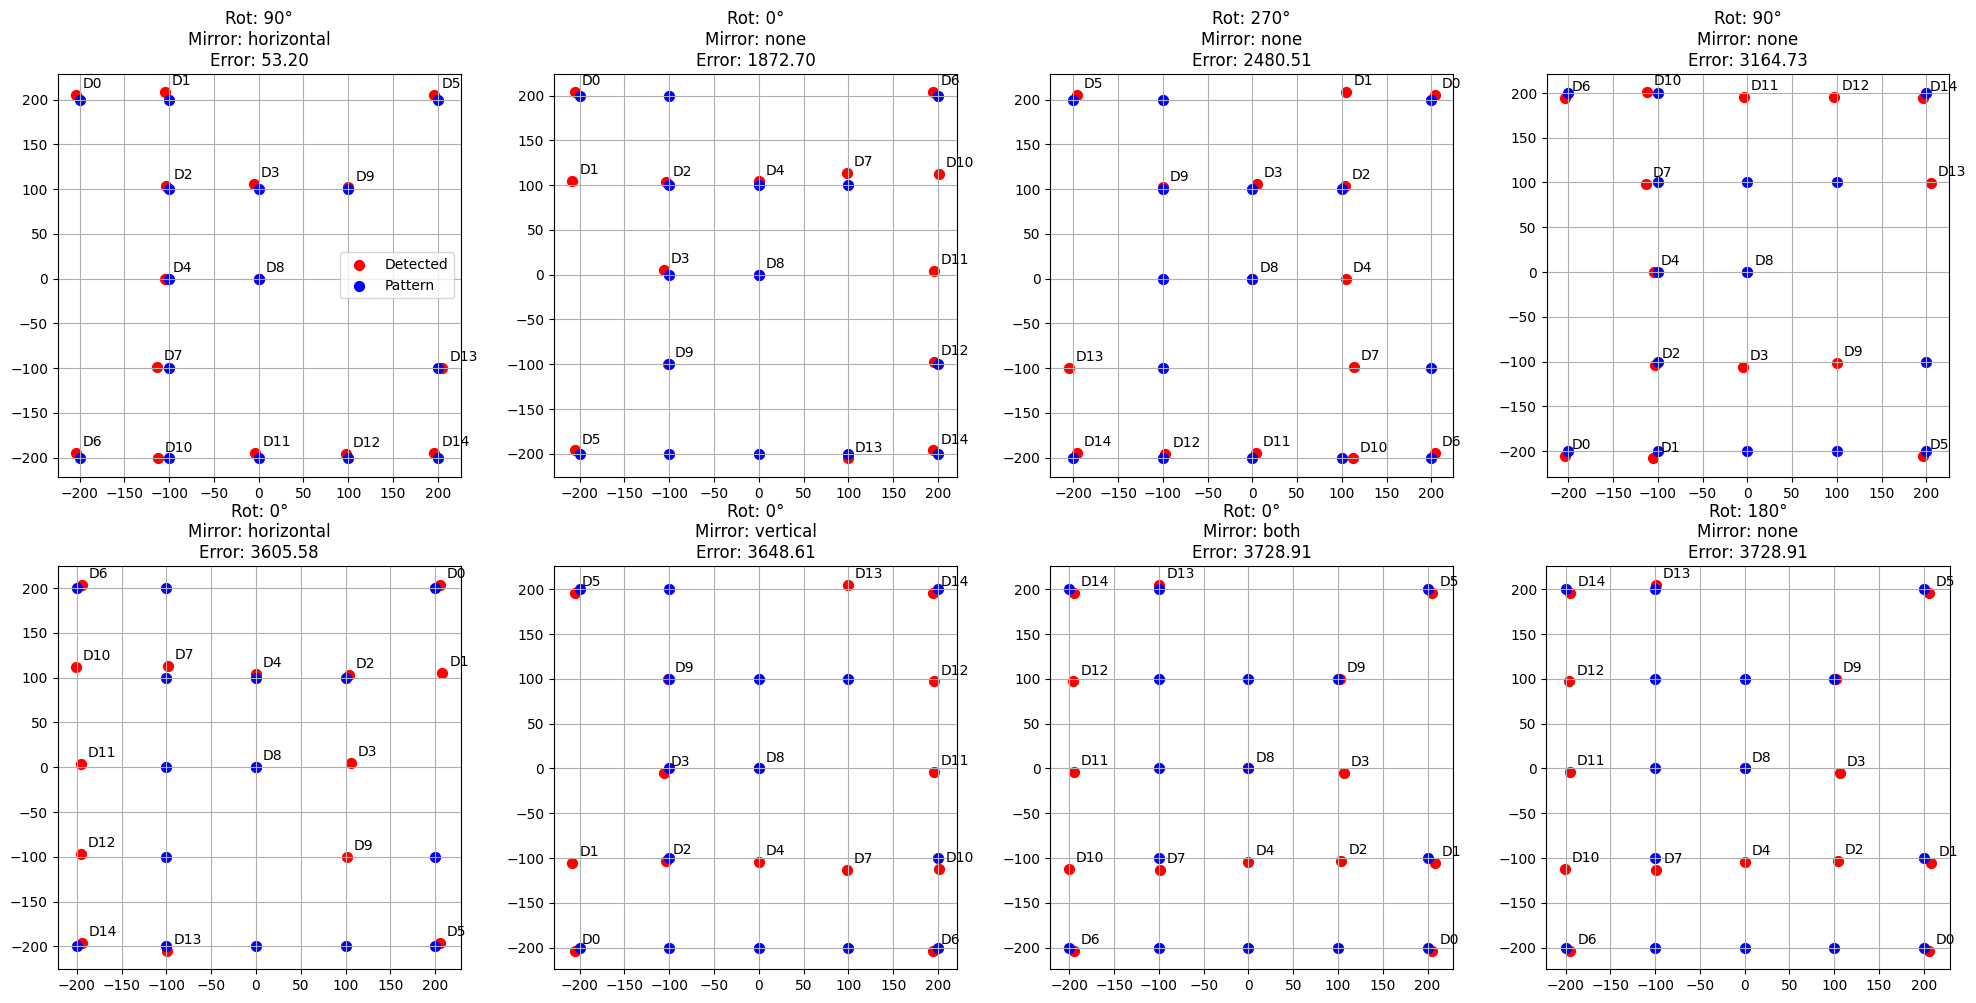

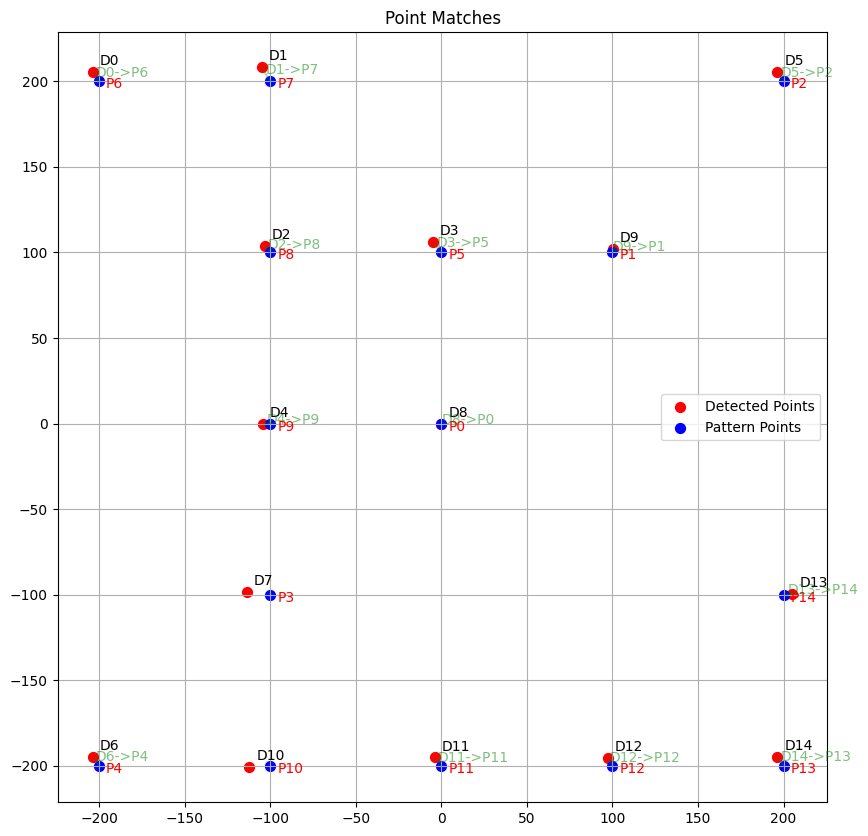

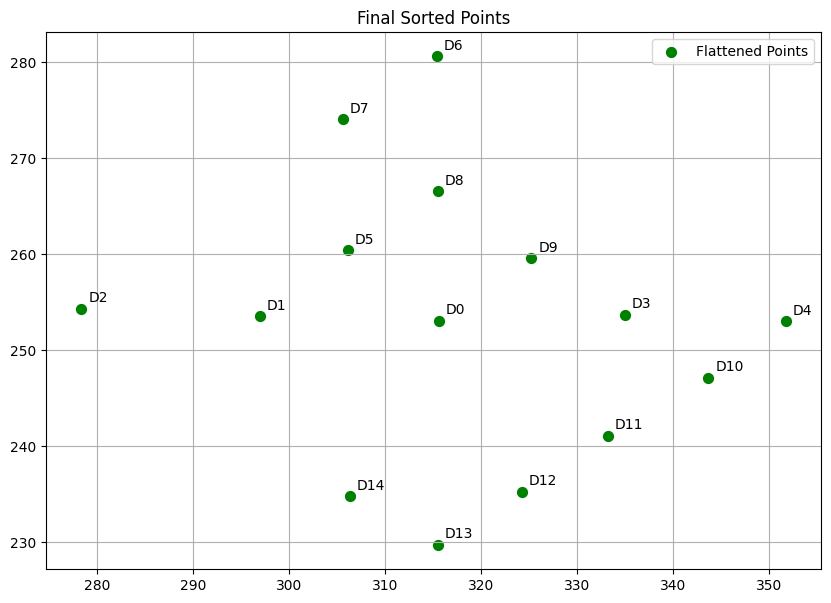

In [14]:
import numpy as np
from scipy.spatial import KDTree
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import cv2

def find_corners(points):
    """Find corners in order: top-left, top-right, bottom-right, bottom-left"""
    points = np.array(points)
    
    # Compute the center of mass
    center = np.mean(points, axis=0)
    
    # Compute angles from center to each point
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    
    # Sort points by angle
    sorted_indices = np.argsort(angles)
    sorted_points = points[sorted_indices]
    
    # If we have many points, we need to find the actual corners
    if len(points) > 4:
        # Use convex hull to find the boundary points
        hull = cv2.convexHull(sorted_points.astype(np.float32))
        hull_points = hull.reshape(-1, 2)
        
        # If hull has more than 4 points, we need to simplify to get 4 corners
        if len(hull_points) > 4:
            # Find the 4 points with maximum distance between them
            # This is a simplification - you might need a more sophisticated approach
            peri = cv2.arcLength(hull, True)
            approx = cv2.approxPolyDP(hull, 0.02 * peri, True)
            corners = approx.reshape(-1, 2)
            
            # Make sure we have exactly 4 corners
            if len(corners) != 4:
                # If not, find the 4 points furthest from each other
                dist_mat = squareform(pdist(hull_points))
                indices = np.zeros(4, dtype=np.int32)
                
                # Start with the two points furthest apart
                i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
                indices[0], indices[1] = i, j
                
                # Find third point furthest from first two
                dist_from_selected = dist_mat[indices[0]] + dist_mat[indices[1]]
                remaining = list(set(range(len(hull_points))) - set(indices[:2]))
                indices[2] = remaining[np.argmax(dist_from_selected[remaining])]
                
                # Find fourth point furthest from first three
                dist_from_selected = (dist_mat[indices[0]] + dist_mat[indices[1]] + 
                                      dist_mat[indices[2]])
                remaining = list(set(range(len(hull_points))) - set(indices[:3]))
                indices[3] = remaining[np.argmax(dist_from_selected[remaining])]
                
                corners = hull_points[indices]
        else:
            corners = hull_points
    else:
        corners = sorted_points
    
    # Ensure we have 4 corners
    if len(corners) != 4:
        raise ValueError(f"Expected 4 corners, but found {len(corners)}")
    
    # Sort corners to top-left, top-right, bottom-right, bottom-left order
    # Sort by x+y value first (to separate diagonal corners)
    corner_sum = corners[:, 0] + corners[:, 1]
    
    # The corner with minimum sum is top-left, maximum sum is bottom-right
    tl_idx = np.argmin(corner_sum)
    br_idx = np.argmax(corner_sum)
    
    # The other two corners can be distinguished by x-y value
    remaining_idx = [i for i in range(4) if i != tl_idx and i != br_idx]
    corner_diff = corners[remaining_idx, 0] - corners[remaining_idx, 1]
    
    # The corner with minimum difference is bottom-left, maximum is top-right
    if corner_diff[0] < corner_diff[1]:
        bl_idx, tr_idx = remaining_idx
    else:
        tr_idx, bl_idx = remaining_idx
    
    # Return corners in the specified order
    return np.array([
        corners[tl_idx],  # top-left
        corners[tr_idx],  # top-right
        corners[br_idx],  # bottom-right
        corners[bl_idx]   # bottom-left
    ])

def flatten_points(points, corners, pattern_size=400):
    """Transform points using homography to flatten perspective"""
    # Define target corners for a normalized square
    dst_corners = np.array([
        [0, 0],
        [pattern_size, 0],
        [pattern_size, pattern_size],
        [0, pattern_size]
    ], dtype=np.float32)
    
    # Calculate homography
    H, _ = cv2.findHomography(corners.astype(np.float32), dst_corners)
    
    # Convert points to homogeneous coordinates
    homog_points = np.column_stack([points, np.ones(len(points))])
    
    # Apply homography
    transformed = H @ homog_points.T
    
    # Convert back from homogeneous coordinates
    transformed = transformed / transformed[2]
    transformed = transformed[:2].T
    
    return transformed

def normalize_coordinates(points, pattern_size=400):
    """Normalize coordinates to match pattern scale"""
    # Find current min/max
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    
    # Scale to pattern range (e.g., -200 to 200 for your pattern)
    scale = 400 / pattern_size  # assuming pattern is -200 to 200
    normalized = (points - min_coords) * scale - 200
    
    return normalized


def transform_points(points, rotation_angle=0, mirror='none'):
    """Apply rotation and/or mirroring to points"""
    # Center points around origin for rotation
    center = np.mean(points, axis=0)
    centered = points - center
    
    # Apply mirroring
    if mirror == 'horizontal':
        centered[:, 0] = -centered[:, 0]  # flip x
    elif mirror == 'vertical':
        centered[:, 1] = -centered[:, 1]  # flip y
    elif mirror == 'both':
        centered = -centered  # flip both
    
    # Rotate
    if rotation_angle != 0:
        theta = np.radians(rotation_angle)
        rot_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        centered = centered @ rot_matrix.T
    
    # Offset all points by nearest point to the origin
    tree = KDTree(centered)
    distances, indices = tree.query(np.zeros_like(centered), k=1)
    centered = centered - centered[indices]

    return centered

def calculate_matching_error(points1, points2):
    """
    Calculate average error using nearest neighbor distances
    points1: transformed detected points
    points2: pattern points
    """
    # Build KD-tree for efficient nearest neighbor search
    tree = KDTree(points2)
    
    # Find nearest pattern point for each detected point
    distances, _ = tree.query(points1)
    
    # Return average distance
    return np.mean(distances**2)

def find_best_transformation(detected_points, pattern_points):
    """Try different transformations and find the best match"""
    best_error = float('inf')
    best_transform = None
    best_points = None
    
    rotations = [0, 90, 180, 270]
    mirrors = ['none', 'horizontal', 'vertical', 'both']
    results = []
    
    for mirror in mirrors:
        for angle in rotations:
            transformed = transform_points(detected_points, angle, mirror)
            error = calculate_matching_error(transformed, pattern_points)
            
            results.append({
                'angle': angle,
                'mirror': mirror,
                'error': error,
                'points': transformed
            })
            
            if error < best_error:
                best_error = error
                best_transform = (angle, mirror)
                best_points = transformed
            if best_error < 100:
                break

    # Sort results by error for visualization
    results.sort(key=lambda x: x['error'])
    return best_points, best_transform, best_error, results

def match_points(detected_points, pattern_points, threshold=10):
    """Match points based on proximity"""
    tree = KDTree(pattern_points)
    distances, indices = tree.query(detected_points)
    
    matches = [(i, idx) for i, (dist, idx) in enumerate(zip(distances, indices))
               if dist < threshold]
    
    return matches

def sort_detected_points(detected_points, pattern_points, matches):
    """Sort detected points to match pattern points order"""
    sorted_points = np.zeros_like(detected_points)
    valid_indices = np.zeros(len(detected_points), dtype=bool)
    
    # Fill in matched points
    for det_idx, pat_idx in matches:
        sorted_points[pat_idx] = detected_points[det_idx]
        valid_indices[pat_idx] = True
    
    # Add unmatched points at the end if any
    unmatched_det = set(range(len(detected_points))) - set(d for d, _ in matches)
    unmatched_pat = set(range(len(pattern_points))) - set(p for _, p in matches)
    
    for det_idx, pat_idx in zip(unmatched_det, unmatched_pat):
        sorted_points[pat_idx] = detected_points[det_idx]
        valid_indices[pat_idx] = True
        
    return sorted_points

# Visualization Functions
def visualize_corners(points, corners, title="Detected Corners"):
    """Visualize detected corners and points with indices"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot all points in red and add indices
    ax.scatter(points[:, 0], points[:, 1], c='red', s=50, label='Points')
    for i, point in enumerate(points):
        ax.annotate(f'D{i}', (point[0], point[1]), xytext=(5, 5), 
                   textcoords='offset points', color='black')
    
    # Plot corners with different colors and labels
    colors = ['g', 'b', 'y', 'm']
    labels = ['TL', 'TR', 'BR', 'BL']
    
    for i, (corner, color, label) in enumerate(zip(corners, colors, labels)):
        ax.scatter(corner[0], corner[1], c=color, s=100, label=f'Corner {label}')
        ax.annotate(label, (corner[0], corner[1]), xytext=(10, 10), 
                   textcoords='offset points')
        
        next_corner = corners[(i+1)%4]
        ax.plot([corner[0], next_corner[0]], 
                [corner[1], next_corner[1]], 
                'b--', alpha=0.5)
    
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    return fig, ax

def visualize_flattened(points, title="Flattened Points"):
    """Visualize flattened points with indices"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot points and add indices
    ax.scatter(points[:, 0], points[:, 1], c='green', s=50, label='Flattened Points')
    for i, point in enumerate(points):
        ax.annotate(f'D{i}', (point[0], point[1]), xytext=(5, 5), 
                   textcoords='offset points', color='black')
    
    ax.grid(True)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.legend()
    return fig, ax

def visualize_transformations(detected_points, pattern_points, results):
    """Visualize all transformations and their errors"""
    n_transforms = len(results)
    n_cols = 4
    n_rows = (n_transforms + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten()
    
    for i, result in enumerate(results):
        ax = axes[i]
        transformed = result['points']
        
        # Plot points
        ax.scatter(transformed[:, 0], transformed[:, 1], c='red', s=50, label='Detected')
        ax.scatter(pattern_points[:, 0], pattern_points[:, 1], c='blue', s=50, label='Pattern')
        
        # Add annotations
        for j, point in enumerate(transformed):
            ax.annotate(f'D{j}', (point[0], point[1]), xytext=(5, 5),
                       textcoords='offset points', color='black')
        
        title = f"Rot: {result['angle']}°\nMirror: {result['mirror']}\nError: {result['error']:.2f}"
        ax.set_title(title)
        ax.grid(True)
        ax.set_aspect('equal')
        
        if i == 0:
            ax.legend()
    
    # Remove empty subplots
    for i in range(n_transforms, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    return fig, axes

def visualize_matches(detected_points, pattern_points, matches, title="Point Matches"):
    """Visualize point matches with indices for both sets"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot detected points in red with indices
    ax.scatter(detected_points[:, 0], detected_points[:, 1], 
              c='red', s=50, label='Detected Points')
    for i, point in enumerate(detected_points):
        ax.annotate(f'D{i}', (point[0], point[1]), xytext=(5, 5), 
                   textcoords='offset points', color='black')
    
    # Plot pattern points in blue with indices
    pattern_points = np.array(pattern_points)
    ax.scatter(pattern_points[:, 0], pattern_points[:, 1], 
              c='blue', s=50, label='Pattern Points')
    for i, point in enumerate(pattern_points):
        ax.annotate(f'P{i}', (point[0], point[1]), xytext=(5, -5), 
                   textcoords='offset points', color='red')
    
    # Draw matches
    for det_idx, pat_idx in matches:
        det_point = detected_points[det_idx]
        pat_point = pattern_points[pat_idx]
        ax.plot([det_point[0], pat_point[0]], 
                [det_point[1], pat_point[1]], 
                'g-', alpha=0.3)
        
        mid_x = (det_point[0] + pat_point[0]) / 2
        mid_y = (det_point[1] + pat_point[1]) / 2
        ax.annotate(f'D{det_idx}->P{pat_idx}', 
                   (mid_x, mid_y), 
                   color='green', 
                   alpha=0.5)
    
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    ax.set_aspect('equal')
    return fig, ax

def debug_matching_pipeline(detected_points, pattern_points):
    """Run full pipeline with all debug visualizations"""
    
    # 1. Find and visualize corners
    corners = find_corners(detected_points)
    fig1, _ = visualize_corners(detected_points, corners)
    
    # 2. Flatten points and visualize
    flattened = flatten_points(detected_points, corners)
    fig2, _ = visualize_flattened(flattened)
    
    # 3. Normalize coordinates and visualize
    normalized = normalize_coordinates(flattened)
    fig3, _ = visualize_flattened(normalized, "Normalized Points")
    
    # 4. Find best transformation
    best_points, (angle, mirror), error, results = find_best_transformation(
        normalized, pattern_points)
    fig4, _ = visualize_transformations(normalized, pattern_points, results)
    
    # 5. Match points with best transformation
    matches = match_points(best_points, pattern_points)
    fig5, _ = visualize_matches(best_points, pattern_points, matches)
    
    # 6. Sort points
    sorted_points = sort_detected_points(detected_points, pattern_points, matches)
    fig6, _ = visualize_flattened(sorted_points, "Final Sorted Points")
    
    print(f"Best transformation: Rotation = {angle}°, Mirror = {mirror}")
    print(f"Average matching error: {error:.2f}")
    
    plt.show()
    return sorted_points, matches, error

def matching_pipeline(detected_points, pattern_points):
    if len(detected_points) != len(pattern_points):
        return None, None, None
    corners = find_corners(detected_points)
    flattened = flatten_points(detected_points, corners)
    normalized = normalize_coordinates(flattened)
    best_points, (angle, mirror), error, results = find_best_transformation(normalized, pattern_points)
    matches = match_points(best_points, pattern_points)
    sorted_points = sort_detected_points(detected_points, pattern_points, matches)
    return sorted_points, matches, error

pattern = load_calibration_pattern()
camera_id = 3
img = frames[camera_id].copy()
sorted_points = points_2d[camera_id]


sorted_points, matches, error = debug_matching_pipeline(sorted_points, pattern.points.copy())


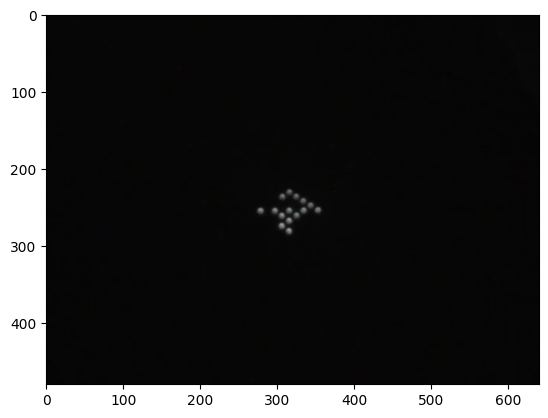

In [15]:
plt.imshow(img)

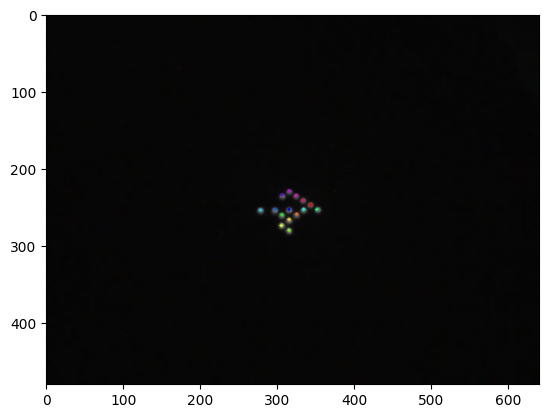

In [16]:
# visualize sorted points and compare it to the pattern points
canvas = img.copy()

for i, point in enumerate(sorted_points):
    hue = int(180 * i / len(sorted_points))  # Gradually change hue
    hsv_color = np.uint8([[[hue, 255, 255]]])
    color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0][0]
    canvas = cv2.circle(canvas, tuple(point.astype(int)), 2, color.tolist(), -1)
plt.imshow(canvas)



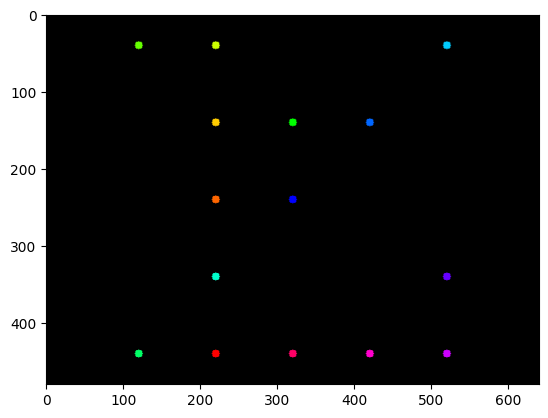

In [17]:
# show pattern points with color gradient
canvas = np.zeros((480, 640, 3), dtype=np.uint8)

pattern_points = pattern.points.copy()
pattern_points[:, 1] = -pattern_points[:, 1]  # Flip Y
# #offset by 320, 240
pattern_points[:, 0] += 320
pattern_points[:, 1] += 240

for i, point in enumerate(pattern_points):
    hue = int(180 * i / len(pattern_points))  # Gradually change hue
    hsv_color = np.uint8([[[hue, 255, 255]]])
    color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0][0]
    canvas = cv2.circle(canvas, tuple(point.astype(int)), 5, color.tolist(), -1)
plt.imshow(canvas)

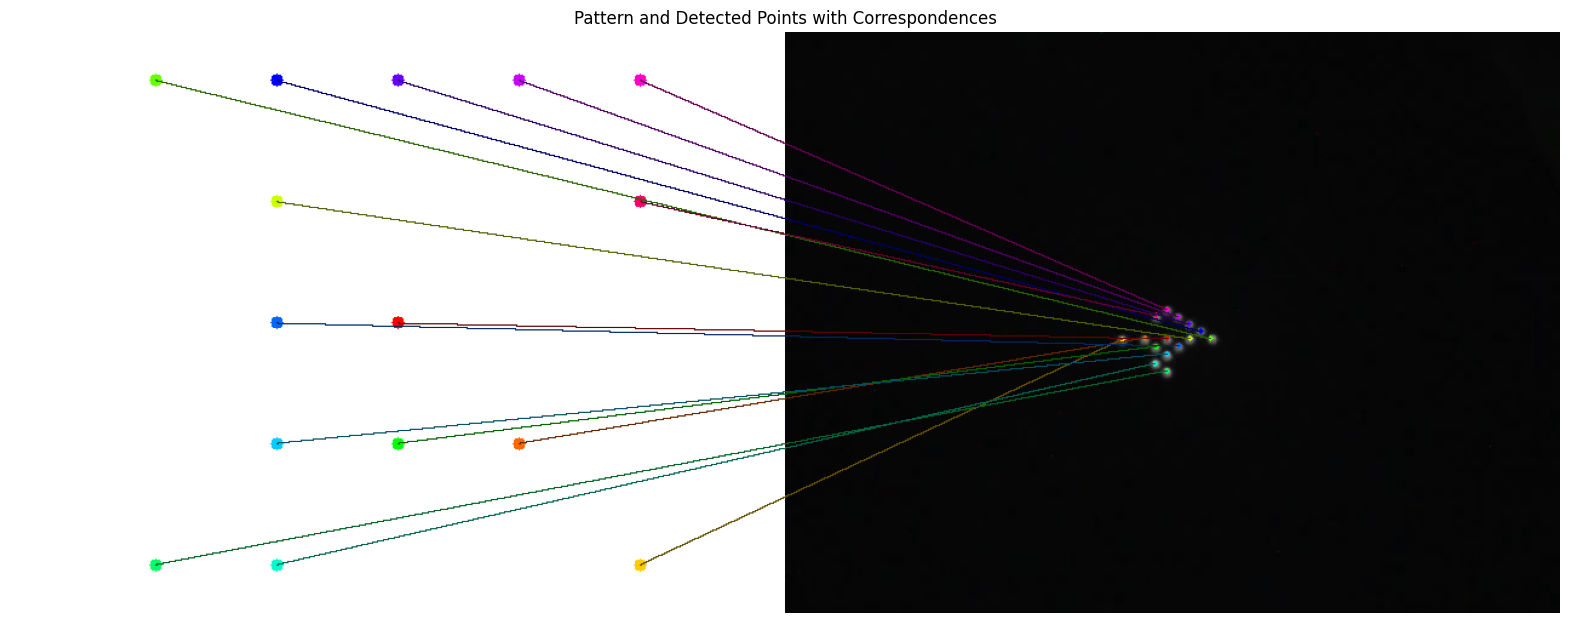

In [18]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np

def visualize_side_by_side_correspondence(detected_img, pattern_points, sorted_points):
    # Create white canvases
    pattern_canvas = np.ones_like(detected_img) * 255
    detected_canvas = detected_img.copy()
    
    # Offset pattern points
    pattern_points_offset = pattern_points.copy()
    pattern_points_offset[:, 0] += 320
    pattern_points_offset[:, 1] += 240
    
    # Draw points with color gradient
    for i, point in enumerate(pattern_points_offset):
        hue = int(180 * i / len(pattern_points_offset))
        hsv_color = np.uint8([[[hue, 255, 255]]])
        color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0][0]
        pattern_canvas = cv2.circle(pattern_canvas, tuple(point.astype(int)), 5, color.tolist(), -1)
    
    for i, point in enumerate(sorted_points):
        hue = int(180 * i / len(sorted_points))
        hsv_color = np.uint8([[[hue, 255, 255]]])
        color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0][0]
        detected_canvas = cv2.circle(detected_canvas, tuple(point.astype(int)), 2, color.tolist(), -1)
    
    # Combine canvases side by side
    combined_canvas = np.zeros((480, 1280, 3), dtype=np.uint8)
    combined_canvas[:, :640] = pattern_canvas
    combined_canvas[:, 640:] = detected_canvas
    
    i = 0
    # Draw correspondence lines
    for pattern_point, sorted_point in zip(pattern_points_offset, sorted_points):
        p1 = pattern_point
        p2 = sorted_point
        
        # Adjust p2 x-coordinate for the side-by-side display
        p2_adjusted = p2.copy()
        p2_adjusted[0] += 640
        
        # Get color for this line
        hue = int(180 * i / len(pattern_points_offset))
        hsv_color = np.uint8([[[hue, 255, 100]]])
        color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0][0].tolist()
        
        cv2.line(combined_canvas, 
                tuple(p1.astype(int)), 
                tuple(p2_adjusted.astype(int)), 
                color, 
                1, 
                cv2.LINE_4)
        i += 1
    
    # Display with matplotlib
    plt.figure(figsize=(20, 8))
    plt.imshow(cv2.cvtColor(combined_canvas, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Pattern and Detected Points with Correspondences')
    plt.show()

# Example usage (with your actual images and points):
# pattern_img = your_first_image
# detected_img = your_second_image
# pattern_points = your_pattern_points
# detected_points = your_detected_points
# matches = list of (pattern_idx, detected_idx) pairs



visualize_side_by_side_correspondence(img, pattern.points.copy(), sorted_points)

In [19]:
# Process all detected_points through the matching pipeline
sorted_points = []
matches = []
error = []
for cam_id in range(len(detected_points)):
    sorted_arr = []
    match_arr = []
    err_arr = []
    for i in range(len(detected_points[cam_id])):
        print(f"Processing frame {i} of camera {cam_id}")
        sp, m, err = matching_pipeline(detected_points[cam_id][i], pattern.points.copy())
        sorted_arr.append(sp)
        match_arr.append(m)
        err_arr.append(err)
    sorted_points.append(sorted_arr)
    matches.append(match_arr)
    error.append(err_arr)


Processing frame 0 of camera 0
Processing frame 1 of camera 0
Processing frame 2 of camera 0
Processing frame 3 of camera 0
Processing frame 4 of camera 0
Processing frame 5 of camera 0
Processing frame 6 of camera 0
Processing frame 7 of camera 0
Processing frame 8 of camera 0
Processing frame 9 of camera 0
Processing frame 10 of camera 0
Processing frame 11 of camera 0
Processing frame 12 of camera 0
Processing frame 13 of camera 0
Processing frame 14 of camera 0
Processing frame 15 of camera 0
Processing frame 16 of camera 0
Processing frame 17 of camera 0
Processing frame 18 of camera 0
Processing frame 19 of camera 0
Processing frame 20 of camera 0
Processing frame 21 of camera 0
Processing frame 22 of camera 0
Processing frame 23 of camera 0
Processing frame 24 of camera 0
Processing frame 25 of camera 0
Processing frame 26 of camera 0
Processing frame 27 of camera 0
Processing frame 28 of camera 0
Processing frame 29 of camera 0
Processing frame 30 of camera 0
Processing frame 3

# Calibrator Position Estimation

Method ITERATIVE: Error = 0.2540, Inliers: 15/15 (1.00)
Method EPNP: Error = 2.8865, Inliers: 15/15 (1.00)
Method AP3P: Error = 2.8865, Inliers: 15/15 (1.00)
Method IPPE: Error = 0.2563, Inliers: 15/15 (1.00)
Selected method: ITERATIVE with error 0.2540
Camera 0 frame 0
rotation matrix:
[[-0.68332155  0.70948881  0.172329  ]
 [ 0.35663196  0.53029959 -0.76915277]
 [-0.63709129 -0.46412064 -0.61539152]]
translation vector:
[[-313.42292641]
 [  86.37078164]
 [4093.14767826]]
reprojection error:
0.25395134
Method ITERATIVE: Error = 0.2487, Inliers: 15/15 (1.00)
Method EPNP: Error = 0.6120, Inliers: 15/15 (1.00)
Method AP3P: Error = 0.6120, Inliers: 15/15 (1.00)
Method IPPE: Error = 0.2483, Inliers: 15/15 (1.00)
Selected method: IPPE with error 0.2483
Camera 1 frame 0
rotation matrix:
[[ 0.71036153  0.70301772 -0.0339497 ]
 [ 0.45071653 -0.49141297 -0.7452301 ]
 [-0.54059328  0.5140811  -0.66594258]]
translation vector:
[[-153.05888747]
 [ -21.0407403 ]
 [4137.02820811]]
reprojection error

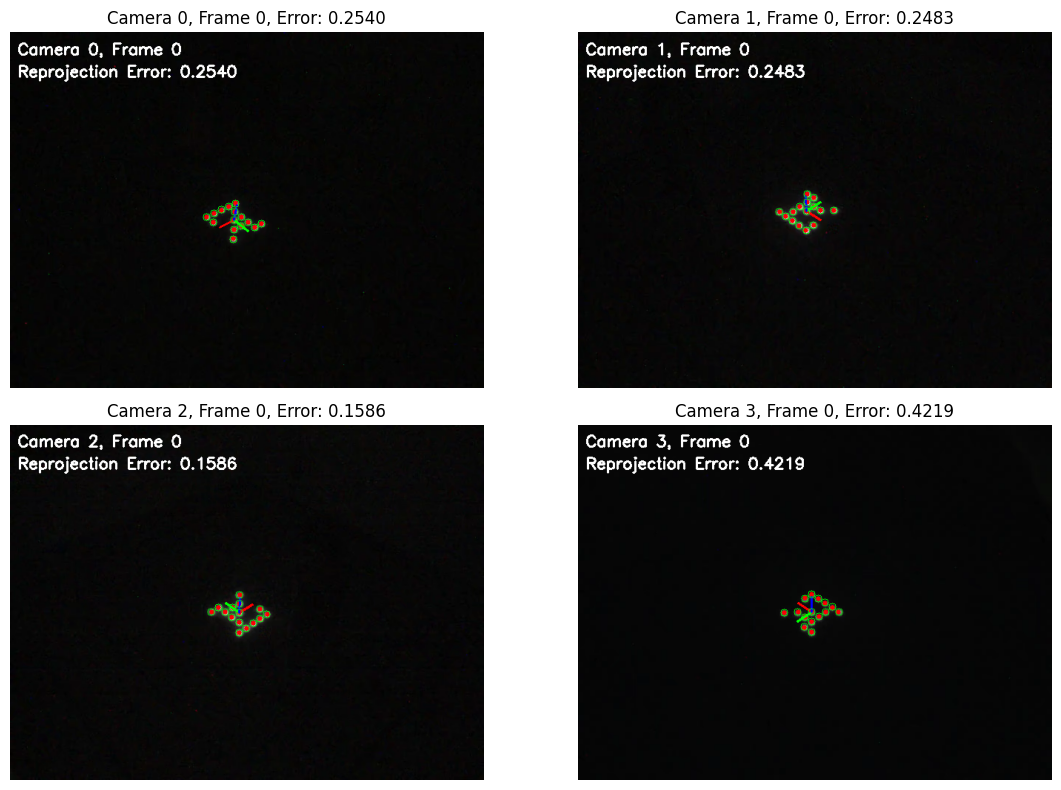

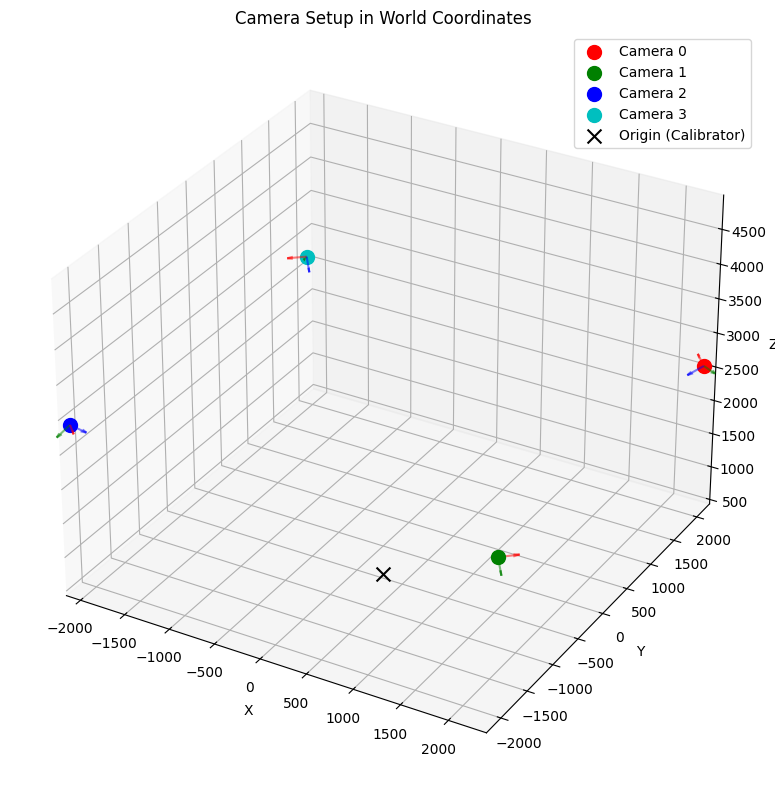

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def estimate_calibrator_pose(pattern_points, image_points, intrinsics: IntrinsicParams):
    """
    Estimate the pose of calibrator relative to the camera using point correspondences.
    
    Args:
        pattern_points: Points of calibration pattern (2D)
        image_points: Detected points in the image
        intrinsics: Camera intrinsic parameters
        
    Returns:
        rotation_matrix: 3x3 rotation matrix of calibrator relative to camera
        translation_vector: 3x1 translation vector of calibrator relative to camera
        error: Reprojection error
    """
    # Input validation
    if image_points is None or len(image_points) == 0:
        print("No image points")
        return None, None, np.inf
    
    if len(image_points) < 6:  # Need at least 6 points for reliable PnP
        print(f"Not enough image points: {len(image_points)}")
        return None, None, np.inf

    # Convert pattern points to 3D by setting Z=0
    pattern_points_3d = np.zeros((len(pattern_points), 3), dtype=np.float32)
    pattern_points_3d[:, :2] = pattern_points  # Copy X,Y coordinates
    
    # Convert points to appropriate format
    image_points = np.array(image_points, dtype=np.float32)
    
    # Try different solvePnP methods
    methods = [
        (cv2.SOLVEPNP_ITERATIVE, "ITERATIVE"),
        (cv2.SOLVEPNP_EPNP, "EPNP"),
        (cv2.SOLVEPNP_AP3P, "AP3P"),
        (cv2.SOLVEPNP_IPPE, "IPPE")
    ]
    
    best_error = np.inf
    best_result = None
    
    for method, method_name in methods:
        try:
            # Use RANSAC for robust estimation
            success, rotation_vector, translation_vector, inliers = cv2.solvePnPRansac(
                pattern_points_3d,
                image_points,
                intrinsics.matrix,
                intrinsics.distortion,
                flags=method,
                reprojectionError=8.0,  # Adjust this threshold based on your setup
                iterationsCount=100
            )
            
            if not success:
                continue
                
            # Calculate reprojection error
            projected_points, _ = cv2.projectPoints(
                pattern_points_3d,
                rotation_vector,
                translation_vector,
                intrinsics.matrix,
                intrinsics.distortion
            )
            projected_points = projected_points.reshape(-1, 2)
            
            # Calculate error using only inliers if available
            if inliers is not None and len(inliers) > 0:
                inlier_indices = inliers.ravel()
                error = np.mean(np.linalg.norm(image_points[inlier_indices] - projected_points[inlier_indices], axis=1))
                inlier_ratio = len(inliers) / len(image_points)
                print(f"Method {method_name}: Error = {error:.4f}, Inliers: {len(inliers)}/{len(image_points)} ({inlier_ratio:.2f})")
            else:
                error = np.mean(np.linalg.norm(image_points - projected_points, axis=1))
                print(f"Method {method_name}: Error = {error:.4f}, No inliers information")
            
            # Keep the best result
            if error < best_error:
                best_error = error
                rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
                best_result = (rotation_matrix, translation_vector, error, method_name)
                
        except Exception as e:
            print(f"Method {method_name} failed: {e}")
    
    if best_result is None:
        return None, None, np.inf
        
    rotation_matrix, translation_vector, error, method_name = best_result
    print(f"Selected method: {method_name} with error {error:.4f}")
    
    return rotation_matrix, translation_vector, error

def draw_calibrator_axes(image, intrinsics, rotation_matrix, translation_vector, axis_length=100, label=False):
    """
    Draw the coordinate axes of the calibrator on the image.
    
    Args:
        image: Image to draw on
        intrinsics: Camera intrinsic parameters
        rotation_matrix: Rotation matrix of calibrator relative to camera
        translation_vector: Translation vector of calibrator relative to camera
        axis_length: Length of axes to draw
        
    Returns:
        Image with axes drawn
    """
    # Convert rotation matrix to rotation vector for projectPoints
    rotation_vector, _ = cv2.Rodrigues(rotation_matrix)
    
    # Define coordinate axes points
    origin = np.float32([[0, 0, 0]])
    x_axis = np.float32([[axis_length, 0, 0]])
    y_axis = np.float32([[0, axis_length, 0]])
    z_axis = np.float32([[0, 0, axis_length]])
    
    # Project axes points to image
    origin_proj, _ = cv2.projectPoints(origin, rotation_vector, translation_vector, 
                                     intrinsics.matrix, intrinsics.distortion)
    x_proj, _ = cv2.projectPoints(x_axis, rotation_vector, translation_vector, 
                                intrinsics.matrix, intrinsics.distortion)
    y_proj, _ = cv2.projectPoints(y_axis, rotation_vector, translation_vector, 
                                intrinsics.matrix, intrinsics.distortion)
    z_proj, _ = cv2.projectPoints(z_axis, rotation_vector, translation_vector, 
                                intrinsics.matrix, intrinsics.distortion)
    
    # Draw axes
    origin_point = tuple(origin_proj.ravel().astype(int))
    x_point = tuple(x_proj.ravel().astype(int))
    y_point = tuple(y_proj.ravel().astype(int))
    z_point = tuple(z_proj.ravel().astype(int))
    
    result = image.copy()
    cv2.line(result, origin_point, x_point, (0, 0, 255), 2)  # X-axis: Red
    cv2.line(result, origin_point, y_point, (0, 255, 0), 2)  # Y-axis: Green
    cv2.line(result, origin_point, z_point, (255, 0, 0), 2)  # Z-axis: Blue
    
    if label:
        # Add axis labels
        cv2.putText(result, 'X', x_point, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        cv2.putText(result, 'Y', y_point, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        cv2.putText(result, 'Z', z_point, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
    
    # Draw detected points and their reprojections for visualization
    return result

def visualize_calibrator_pose(cam_id, frame_num, video_frames, sorted_points, pattern_points, intrinsics):
    """
    Visualize the calibrator pose for a specific camera and frame.
    
    Args:
        cam_id: Camera ID
        frame_num: Frame number
        video_frames: List of video frames [cam_id][frame_num]
        sorted_points: List of detected points [cam_id][frame_num]
        pattern_points: Points of calibration pattern
        intrinsics: List of camera intrinsic parameters [cam_id]
        
    Returns:
        Image with calibrator axes drawn, rotation matrix, translation vector, error
    """
    # Get the frame and points
    frame = video_frames[cam_id][frame_num].copy()
    image_points = sorted_points[cam_id][frame_num]
    
    # Draw the detected points
    if image_points is not None:
        for point in image_points:
            cv2.circle(frame, tuple(point.astype(int)), 3, (0, 0, 255), -1)
    
    # Estimate calibrator pose
    rotation_matrix, translation_vector, error = estimate_calibrator_pose(
        pattern_points,
        image_points,
        intrinsics[cam_id]
    )
    
    # Draw calibrator axes
    result = frame.copy()
    if rotation_matrix is not None and translation_vector is not None:
        result = draw_calibrator_axes(
            frame,
            intrinsics[cam_id],
            rotation_matrix,
            translation_vector,
            axis_length=200  # Adjust based on your pattern size
        )
        
        # Also draw the pattern points projected back to verify calibration
        pattern_points_3d = np.zeros((len(pattern_points), 3), dtype=np.float32)
        pattern_points_3d[:, :2] = pattern_points
        
        rotation_vector, _ = cv2.Rodrigues(rotation_matrix)
        projected_points, _ = cv2.projectPoints(
            pattern_points_3d,
            rotation_vector,
            translation_vector,
            intrinsics[cam_id].matrix,
            intrinsics[cam_id].distortion
        )
        
        # Draw reprojected points in green
        for point in projected_points:
            point = point.ravel()
            cv2.circle(result, (int(point[0]), int(point[1])), 5, (0, 255, 0), 1)
    
    # Add information text
    cv2.putText(result, f"Camera {cam_id}, Frame {frame_num}", (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    cv2.putText(result, f"Reprojection Error: {error:.4f}", (10, 60), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    return result, rotation_matrix, translation_vector, error

def compute_camera_positions(rotation_matrices, translation_vectors):
    """
    Compute camera positions in world coordinates.
    
    In computer vision, the extrinsic parameters (R, t) represent the transform 
    from world to camera coordinates. To get camera position in world coordinates,
    we need to invert this transform.
    
    Args:
        rotation_matrices: List of rotation matrices [cam_id]
        translation_vectors: List of translation vectors [cam_id]
        
    Returns:
        camera_positions: List of camera positions in world coordinates [cam_id]
    """
    camera_positions = []
    
    for R, t in zip(rotation_matrices, translation_vectors):
        if R is None or t is None:
            camera_positions.append(None)
            continue
            
        # Camera position in world coordinates: C = -R^T * t
        C = -np.matmul(R.T, t)
        camera_positions.append(C)
    
    return camera_positions

def visualize_camera_setup(camera_positions, rotation_matrices):
    """
    Visualize the camera setup in 3D with rotation axes.
    
    Args:
        camera_positions: List of camera positions in world coordinates [cam_id]
        rotation_matrices: List of rotation matrices [cam_id]
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define camera colors
    colors = ['r', 'g', 'b', 'c']
    
    # Plot camera positions and rotation axes
    for i, (pos, R) in enumerate(zip(camera_positions, rotation_matrices)):
        if pos is not None and R is not None:
            # Plot camera position
            ax.scatter(pos[0], pos[1], pos[2], c=colors[i], marker='o', s=100, label=f'Camera {i}')
            
            # Plot rotation axes (scaled for visibility)
            scale = 200  # Adjust scale factor as needed
            origin = pos.flatten()
            
            # X axis (red)
            x_axis = origin + scale * R.T[:, 0]
            ax.quiver(origin[0], origin[1], origin[2], 
                     x_axis[0]-origin[0], x_axis[1]-origin[1], x_axis[2]-origin[2],
                     color='r', alpha=0.5)
            
            # Y axis (green)
            y_axis = origin + scale * R.T[:, 1]
            ax.quiver(origin[0], origin[1], origin[2], 
                     y_axis[0]-origin[0], y_axis[1]-origin[1], y_axis[2]-origin[2],
                     color='g', alpha=0.5)
            
            # Z axis (blue)
            z_axis = origin + scale * R.T[:, 2]
            ax.quiver(origin[0], origin[1], origin[2], 
                     z_axis[0]-origin[0], z_axis[1]-origin[1], z_axis[2]-origin[2],
                     color='b', alpha=0.5)
    
    # Plot the origin (calibration pattern position in first frame)
    ax.scatter(0, 0, 0, c='k', marker='x', s=100, label='Origin (Calibrator)')
    
    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Add a legend
    ax.legend()
    
    # Make the plot more readable
    ax.set_title('Camera Setup in World Coordinates')
    
    # Ensure equal aspect ratio
    max_range = np.array([
        np.max([pos[0] for pos in camera_positions if pos is not None]) - 
        np.min([pos[0] for pos in camera_positions if pos is not None]),
        np.max([pos[1] for pos in camera_positions if pos is not None]) - 
        np.min([pos[1] for pos in camera_positions if pos is not None]),
        np.max([pos[2] for pos in camera_positions if pos is not None]) - 
        np.min([pos[2] for pos in camera_positions if pos is not None])
    ]).max() / 2.0
    
    mid_x = np.mean([pos[0] for pos in camera_positions if pos is not None])
    mid_y = np.mean([pos[1] for pos in camera_positions if pos is not None])
    mid_z = np.mean([pos[2] for pos in camera_positions if pos is not None])
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tight_layout()
    return fig

frame_num = 0

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
rotation_matrices = []
translation_vectors = []
errors = []

# Calculate and Visualize for each camera
for cam_id in range(len(video_frames)):
    result, rotation_matrix, translation_vector, error = visualize_calibrator_pose(
        cam_id, 
        frame_num, 
        video_frames, 
        sorted_points, 
        pattern.points.copy(), 
        intrinsics
    )
    
    rotation_matrices.append(rotation_matrix)
    translation_vectors.append(translation_vector)
    errors.append(error)

    # Display the result
    ax[cam_id // 2, cam_id % 2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax[cam_id // 2, cam_id % 2].set_title(f"Camera {cam_id}, Frame {frame_num}, Error: {error:.4f}")
    ax[cam_id // 2, cam_id % 2].axis('off')

    # Print the rotation matrix and translation vector
    print(f"Camera {cam_id} frame {frame_num}")
    print(f"rotation matrix:")
    print(rotation_matrix)
    print(f"translation vector:")
    print(translation_vector)
    print(f"reprojection error:")
    print(error)

plt.tight_layout()
plt.savefig("calibration_results.png")

# Compute and visualize camera positions with rotation
camera_positions = compute_camera_positions(rotation_matrices, translation_vectors)
fig_3d = visualize_camera_setup(camera_positions, rotation_matrices)
fig_3d.savefig("camera_setup_3d.png")

# Print camera positions
print("\nCamera positions in world coordinates:")
for i, pos in enumerate(camera_positions):
    if pos is not None:
        print(f"Camera {i}: X={pos[0][0]:.2f}, Y={pos[1][0]:.2f}, Z={pos[2][0]:.2f}")

# Check if cameras roughly form a rectangle/square
if all(pos is not None for pos in camera_positions):
    # Check if cameras are roughly in a plane (Z coordinates should be similar)
    z_coords = [pos[2][0] for pos in camera_positions]
    z_variation = np.std(z_coords)
    print(f"\nZ-coordinate variation: {z_variation:.2f}")
    
    # Check if cameras form a rectangle by computing the distances between them
    print("\nInter-camera distances:")
    for i in range(len(camera_positions)):
        for j in range(i+1, len(camera_positions)):
            dist = np.linalg.norm(camera_positions[i] - camera_positions[j])
            print(f"Distance between Camera {i} and Camera {j}: {dist:.2f}")


In [34]:
# Insert initial rotation matrix and translation vector into initial_extrinsics
initial_extrinsics = {}
for cam_id in range(len(video_frames)):
    initial_extrinsics[cam_id] = ExtrinsicParams(t=translation_vectors[cam_id], R=rotation_matrices[cam_id])

import json
from pathlib import Path
from typing import Dict

def save_extrinsic_params(extrinsic: Dict[int, ExtrinsicParams], filename: str = "camera-extrinsic.json") -> None:
    """Save extrinsic parameters to JSON file"""
    path = Path(filename)
    data = []
    
    # Create data list from current parameters
    for camera_id, params in extrinsic.items():
        cam_data = params.to_dict()
        cam_data['camera_id'] = camera_id
        data.append(cam_data)
    
    # Save to file (overwriting any existing content)
    with path.open('w') as f:
        json.dump(data, f, indent=4)

save_extrinsic_params(initial_extrinsics)


In [22]:
# print real world coordinates of all cameras
for cam_id in range(len(video_frames)):
    print(f"Camera {cam_id} real world coordinates:")
    print(-np.matmul(rotation_matrices[cam_id].T, translation_vectors[cam_id]))


Camera 0 real world coordinates:
[[2362.73749599]
 [2076.28198129]
 [2639.33257055]]
Camera 1 real world coordinates:
[[ 2354.66022192]
 [-2029.50461093]
 [ 2734.14674149]]
Camera 2 real world coordinates:
[[-2191.50696833]
 [-2039.13055093]
 [ 2770.62970775]]
Camera 3 real world coordinates:
[[-2059.49846041]
 [ 2017.45436292]
 [ 2693.57596811]]


## Bundle Adjustment

In [23]:
import numpy as np
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation

def bundle_adjustment(sorted_points, intrinsics:IntrinsicParams, initial_extrinsics:ExtrinsicParams, num_points=15):
    """
    sorted_points: list or array, shape [num_cams][num_frames][15, 2] or [0, 2] if missing
    intrinsics: list or dict of IntrinsicParams, one per camera
    initial_extrinsics: list or dict of ExtrinsicParams, one per camera
    Returns: optimized_extrinsics, optimized_3d_points
    """
    num_cams = len(sorted_points)
    num_frames = min(len(frames) for frames in sorted_points)

    # Find valid frames: all cameras have 15 points
    valid_frames = []
    for f in range(num_frames):
        if all(sorted_points[cam][f] is not None and len(sorted_points[cam][f]) == num_points for cam in range(num_cams)):
            valid_frames.append(f)
    print(f"Using {len(valid_frames)} valid frames for bundle adjustment.")

    # Build 2D observations: shape (num_points, num_cams, num_valid_frames, 2)
    obs = np.zeros((num_points, num_cams, len(valid_frames), 2))
    for fi, f in enumerate(valid_frames):
        for ci in range(num_cams):
            obs[:, ci, fi, :] = sorted_points[ci][f]

    # Initial guess for 3D points: triangulate using first frame and initial extrinsics
    def triangulate_nview(points_2d, Ps):
        A = []
        for i, pt in enumerate(points_2d):
            x, y = pt
            P = Ps[i]
            A.append(x * P[2, :] - P[0, :])
            A.append(y * P[2, :] - P[1, :])
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        X = X / X[3]
        return X[:3]

    Ps = []
    for ci in range(num_cams):
        ext = initial_extrinsics[ci]
        RT = np.hstack([ext.R, ext.t.reshape(3,1)])
        P = intrinsics[ci].matrix @ RT
        Ps.append(P)
    Ps = np.array(Ps)

    X0 = []
    for pi in range(num_points):
        pts_2d = obs[pi, :, 0, :]  # Use first valid frame
        X0.append(triangulate_nview(pts_2d, Ps))
    X0 = np.array(X0).reshape(-1)

    # Initial guess for extrinsics: rotation vector + translation for each camera
    extr0 = []
    for ci in range(num_cams):
        ext = initial_extrinsics[ci]
        rvec = np.asarray(Rotation.from_matrix(ext.R).as_rotvec()).flatten()
        tvec = np.asarray(ext.t).flatten()
        extr0.extend(rvec.tolist())
        extr0.extend(tvec.tolist())
    extr0 = np.array(extr0, dtype=np.float64)

    # Full parameter vector: [X0, extr0]
    x0 = np.concatenate([X0, extr0])

    def pack_params(X, extr):
        return np.concatenate([X.reshape(-1), extr.reshape(-1)])

    def unpack_params(x):
        X = x[:num_points*3].reshape((num_points, 3))
        extr = x[num_points*3:].reshape((num_cams, 6))
        return X, extr

    def project(X, rvec, tvec, K):
        R = Rotation.from_rotvec(rvec).as_matrix()
        Xc = R @ X + tvec
        x_proj = K @ Xc
        return x_proj[:2] / x_proj[2]

    def residuals(x):
        X, extr = unpack_params(x)
        res = []
        for fi, f in enumerate(valid_frames):
            for ci in range(num_cams):
                K = intrinsics[ci].matrix
                rvec = extr[ci, :3]
                tvec = extr[ci, 3:]
                for pi in range(num_points):
                    x_proj = project(X[pi], rvec, tvec, K)
                    obs_2d = obs[pi, ci, fi, :]
                    res.extend(x_proj - obs_2d)
        return np.array(res)

    # Run optimization
    result = least_squares(residuals, x0, verbose=2, method='lm', max_nfev=20)

    # Unpack results
    X_opt, extr_opt = unpack_params(result.x)
    optimized_extrinsics = []
    for ci in range(num_cams):
        R_opt = Rotation.from_rotvec(extr_opt[ci, :3]).as_matrix()
        t_opt = extr_opt[ci, 3:]
        optimized_extrinsics.append(type(initial_extrinsics[ci])(R=R_opt, t=t_opt))
    return optimized_extrinsics, X_opt

In [24]:
## DEPRECATED

# import numpy as np
# import cv2
# from dataclasses import dataclass
# from typing import Dict, Any, List
# from scipy.optimize import least_squares


# def flatten_extrinsics(extrinsics: Dict[int, ExtrinsicParams]) -> np.ndarray:
#     flattened = []
#     for cam_id, extr in extrinsics.items():
#         rvec, _ = cv2.Rodrigues(extr.R)
#         flattened.append(rvec.flatten())
#         flattened.append(extr.t.flatten())
#     return np.concatenate(flattened)

# def unpack_extrinsics(params: np.ndarray, n_cams: int) -> List[ExtrinsicParams]:
#     extrinsics = []
#     for cam_idx in range(n_cams):
#         rvec = params[cam_idx * 6 : cam_idx * 6 + 3]
#         tvec = params[cam_idx * 6 + 3 : cam_idx * 6 + 6]
#         R = cv2.Rodrigues(rvec)[0]
#         t = tvec
#         extrinsics.append(ExtrinsicParams(t=t, R=R))
#     return extrinsics

# def prepare_observations(sorted_points, n_cams, n_frames, n_points):
#     observations = []
#     visibility = []
#     for cam_id in range(n_cams):
#         cam_obs = []
#         cam_vis = []
#         for frame in range(n_frames):
#             frame_data = sorted_points[cam_id][frame]
#             if frame_data is not None and len(frame_data) == n_points:
#                 cam_obs.append(frame_data)
#                 cam_vis.append([True] * n_points)
#             else:
#                 cam_obs.append([[np.nan, np.nan]] * n_points)
#                 cam_vis.append([False] * n_points)
#         observations.append(cam_obs)
#         visibility.append(cam_vis)
#     return np.array(observations), np.array(visibility)

# def bundle_residuals(params, n_cams, n_frames, n_points, led_positions, intrinsics, observations, visibility):
#     residuals = np.zeros((n_cams, n_frames, n_points, 2), dtype=np.float32)

#     for cam_idx in range(n_cams):
#         rvec = params[cam_idx * 6 : cam_idx * 6 + 3]
#         tvec = params[cam_idx * 6 + 3 : cam_idx * 6 + 6]
#         R = cv2.Rodrigues(rvec)[0]
#         t = tvec.reshape((3, 1))
#         K = intrinsics[cam_idx].matrix

#         for frame_idx in range(n_frames):
#             for pt_idx in range(n_points):
#                 if not visibility[cam_idx, frame_idx, pt_idx]:
#                     continue

#                 X = led_positions[pt_idx].reshape((3, 1))
#                 X_cam = R @ X + t
#                 if not np.isfinite(X_cam).all() or X_cam[2] <= 1e-6:
#                     continue  # leave as [0, 0] residual

#                 x_proj = K @ X_cam
#                 x_proj /= x_proj[2]
#                 x_proj_2d = x_proj[:2].flatten()

#                 x_obs = observations[cam_idx, frame_idx, pt_idx]
#                 if not np.isfinite(x_obs).all():
#                     continue  # observation is missing or invalid

#                 residuals[cam_idx, frame_idx, pt_idx] = x_proj_2d - x_obs

#     return residuals[visibility].reshape(-1)

# # === MAIN EXECUTION ===

# led_positions = sorted_points
# led_positions_3d = np.hstack([pattern.points.copy(), np.full((led_positions.shape[0], 1), 1.0)])


# n_cams = len(intrinsics)
# n_frames = len(sorted_points[0])
# n_points = led_positions.shape[0]

# observations, visibility = prepare_observations(sorted_points, n_cams, n_frames, n_points)


# initial_params = flatten_extrinsics(initial_extrinsics)

# result = least_squares(
#     bundle_residuals,
#     x0=initial_params,
#     verbose=2,
#     method='trf',
#     loss='cauchy',
#     args=(n_cams, n_frames, n_points, led_positions_3d, intrinsics, observations, visibility),
#     max_nfev=20
# )

# optimized_extrinsics = unpack_extrinsics(result.x, n_cams)


In [25]:
pattern.points.copy()

array([[   0.,    0.],
       [ 100.,  100.],
       [ 200.,  200.],
       [-100., -100.],
       [-200., -200.],
       [   0.,  100.],
       [-200.,  200.],
       [-100.,  200.],
       [-100.,  100.],
       [-100.,    0.],
       [-100., -200.],
       [   0., -200.],
       [ 100., -200.],
       [ 200., -200.],
       [ 200., -100.]])

In [26]:
optimized_extrinsics, optimized_3d_points = bundle_adjustment(sorted_points, intrinsics, initial_extrinsics)


Using 623 valid frames for bundle adjustment.
The maximum number of function evaluations is exceeded.
Function evaluations 71, initial cost 1.2439e+08, final cost 1.2439e+08, first-order optimality 2.61e+06.


In [27]:
optimized_extrinsics

[ExtrinsicParams(t=array([-313.42292641,   86.37078164, 4093.14767826]), R=array([[-0.68332155,  0.70948881,  0.172329  ],
        [ 0.35663196,  0.53029959, -0.76915277],
        [-0.63709129, -0.46412064, -0.61539152]])),
 ExtrinsicParams(t=array([-153.05888747,  -21.0407403 , 4137.02820811]), R=array([[ 0.71036153,  0.70301772, -0.0339497 ],
        [ 0.45071653, -0.49141297, -0.7452301 ],
        [-0.54059328,  0.5140811 , -0.66594258]])),
 ExtrinsicParams(t=array([-170.01169648,   77.52241534, 4074.58359487]), R=array([[ 0.6907546 , -0.71879188,  0.07871666],
        [-0.43842918, -0.50290302, -0.7448949 ],
        [ 0.57501125,  0.48002789, -0.66252191]])),
 ExtrinsicParams(t=array([-235.60897303,   34.76579032, 3938.31020395]), R=array([[-0.73856191, -0.67363226,  0.02731098],
        [-0.47045294,  0.48593588, -0.73657338],
        [ 0.48290821, -0.55685357, -0.67580601]]))]

In [32]:
# transform optimized extrinsics to dict
optimized_extrinsics_dict = {}
for cam_id, extr in enumerate(optimized_extrinsics):
    optimized_extrinsics_dict[cam_id] = ExtrinsicParams(t=extr.t, R=extr.R)

In [33]:
save_extrinsic_params(optimized_extrinsics_dict, filename="optimized_extrinsics.json")


In [30]:
# print real world coordinates of all cameras
for cam_id in range(len(video_frames)):
    print(f"Camera {cam_id} real world coordinates:")
    print(-np.matmul(optimized_extrinsics[cam_id].R.T, optimized_extrinsics[cam_id].t))

Camera 0 real world coordinates:
[2362.73749599 2076.28198129 2639.33257055]
Camera 1 real world coordinates:
[ 2354.66022192 -2029.50461093  2734.14674149]
Camera 2 real world coordinates:
[-2191.50696833 -2039.13055093  2770.62970775]
Camera 3 real world coordinates:
[-2059.49846041  2017.45436292  2693.57596811]
